# Prevendo Customer Churn em Operadoras de Telecom

![Churn](images/churn.png)

## Objetivos pessoais:
**Objetivo 1:**
Empregar conhecimentos da ferramenta Apache Spark, a qual é grande aliada do Big Data, sendo amplamente utilizada para trabalhar em clusters de computadores pois seu armazenamento é em memória, o que permite uma computação rápida e até mesmo ações em tempo real.

**Objetivo 2:** 
Aplicar técnicas de EDA, preparação dos dados e Machine Learning para prever clientes com risco de churn.

## Contexto:

Customer churn, também conhecido como churn rate, é um indicador que mede o índice de evasão dos clientes, ou seja, a taxa de cancelamento de um determinado serviço. Baseado nessas informações, é possível criar um modelo de machine learning que prevê quais clientes possuem potencial probabilidade para cancelar o relacionamento comercial com a empresa e de alguma forma criar tarefas para reter esses clientes.

## Problema de Negócio: 


A empresa X é uma grande empresa do ramo de telecomunicações. Ela detém em sua base de dados em média cerca de 20 milhões de clientes ao ano, os quais possuem um plano fixo de internet e telefone móvel. Entretanto, nos últimos anos, sua base de clientes vem diminuindo pouco a pouco, causando um certo questionamento na empresa. Após algumas conversas, percebe-se que muitos clientes estão terminando o relacionamento comercial após o fim do contrato, devido à expansão do setor de telecomunicações e a grande competitivdade entre as empresas desse setor.

Pensando nisso, a empresa X procurou você, como cientista de dados, a fim de gerar insights necessários para a equipe de relações comerciais. Seu trabalho é encontrar potênciais clientes que tem probabilidade de deixar a empresa e direcionar à equipe comercial à eles, sendo possível lançar promoções e manter os clientes para o ano seguinte.

Ao final do projeto, o CEO necessita que as seguintes perguntas sejam respondidas:

- Qual é o Churn Rate da Operadora hoje?
- Qual é a performance do modelo ao classificar clientes em Churn?



## Plano de Ação:

- Carregar os dados utilizando Apache Spark
- Descrição dos dados
- Criação do Mapa de Hipóteses
- Feature Engineering
- Filtragem de variáveis
- Análise Exploratória de Dados
- Preparando dados de teste
- Preparação dos dados
- Escolha de Features
- Modelos de Machine Learning
- Hyperparameter Fine-Tuning
- Performance do melhor modelo


## 0.0 Módulos Utilizados 

In [29]:
# Imports
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import PCA
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from sklearn.preprocessing import MinMaxScaler, StandardScaler

## 0.1 Funções Úteis

In [30]:
# Estilo do plot
sns.set_style('whitegrid')

# Display com numero ilimitado de linhas e colunas
pd.options.display.max_columns = None
pd.options.display.max_rows = None

**set_plot_features**

In [31]:
# Edita o plot
def set_plots_features(ax, title, xlabel, ylabel):
    """This function customize a plot

    Args:
        ax ([axe]): Axes plot
        title ([str]): String title
        xlabel([str]): String label for x-axis
        ylabel([str]): String label for y-axis


    """

    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

**transformData2DF**

In [32]:
# Transformando os dados para transformar em dataframe
def transformData2DF( inputStr) :
    """This function prepare data (csv stored in a RDD) creating Rows object to put in a Pyspark Dataframe 

    Args:
        inputStr ([str]): line of a csv


    Returns:
        lines([object]: Row object
    """

    attList = inputStr.split(',')

    area_code = int(attList[3].split('_')[-1][:-1])

    # Cria as linhas com os objetos transformados
    lines = Row(id_num = int(attList[0].strip("\"")), state = attList[1].strip("\""), account_length  = int(attList[2]), area_code  = area_code, international_plan = attList[4].strip("\""),
               voice_mail_plan = attList[5].strip("\""), number_vmail_messages = int(attList[6]), total_day_minutes = float(attList[7]), total_day_calls= int(attList[8]),
               total_day_charge = float(attList[9]), total_eve_minutes = float(attList[10]), total_eve_calls= int(attList[11]), total_eve_charge = float(attList[12]),
               total_night_minutes = float(attList[13]), total_night_calls= int(attList[14]), total_night_charge = float(attList[15]), total_intl_minutes = float(attList[16]),
               total_intl_calls= int(attList[17]), total_intl_charge = float(attList[18]), number_customer_service_calls = int(attList[19]), churn = attList[20].strip("\"")) 
    return lines

**descriptive_statistics**

In [33]:
def descriptive_statistics(num_var):
    """This function creates a dataframe of descriptive statistics, with central tendency and dispersion measures

    Args:
        num_var([dataframe]): dataframe of numerical variables

    Returns:
        stats([dataframe]): resume of statistics in a dataframe 
    """

    # Central Tendency
    mean_df = pd.DataFrame(num_var.apply(np.mean)).T
    median_df = pd.DataFrame(num_var.apply(np.median)).T

    # Dispersion - Std, min, max, range, skew, kurtosis
    disp1 = pd.DataFrame(num_var.apply(np.std)).T
    disp2 = pd.DataFrame(num_var.apply(min)).T
    disp3 = pd.DataFrame(num_var.apply(max)).T
    disp4 = pd.DataFrame(num_var.apply(lambda x: x.max() - x.min())).T
    disp5 = pd.DataFrame(num_var.apply(lambda x: x.skew())).T
    disp6 = pd.DataFrame(num_var.apply(lambda x: x.kurtosis())).T


    # Concatenate
    stats = pd.concat([mean_df, median_df, disp1, disp2, disp3, disp4, disp5, disp6]).T.reset_index()
    stats.columns = ["variable", "mean", "median", "std", "min", "max", "range", "skew","kurtosis"]


    return stats

**find_distribution_outliers**

In [34]:
def find_distribution_outliers(col_name, bins = 10):
    """This function creates distribution and box plots for better understand of data and find outliers

    Args:
        col_name([str]): Column name 
        bins([int]): Number of bins


    """

    figure, ax = plt.subplots(figsize=(12,12))

    plt.subplot(2,1,1)
    ax = sns.distplot(train_df_pandas[col_name], bins = bins)
    set_plots_features(ax, "Distribuição dos dados para {}".format(col_name), col_name, "Density")

    plt.subplot(2,1,2)
    ax = sns.boxplot(train_df_pandas[col_name])

    # Calculates Q1, Q3 and IQR
    Q1 = np.quantile(train_df_pandas[col_name], 0.25)
    Q3 = np.quantile(train_df_pandas[col_name], 0.75)
    IQR = Q3 - Q1

    # Calculates the outliers boundaries through statistical relationship
    low_outliers = Q1 - 1.5 * IQR
    high_outliers = Q3 + 1.5 * IQR

    print('Limites de Outliers para {}:'.format(col_name))
    print(f"Q1 = {Q1}\nQ3 = {Q3}\nIQR = {IQR}\nlow_outliers = {low_outliers}\nhigh_outliers = {high_outliers}")

**convert_numerical**

In [391]:
def convert_numerical(df):
    """This function convert categorical data to numbers, with encodings

    Args:
        df([dataframe]): Dataframe

    Returns:
        final_df([dataframe]): Dataframe after encoding
    """
        
    # Encodings
    df = df.withColumn("international_plan", when(df["international_plan"] == "yes", 1).otherwise(0))
    df = df.withColumn("churn", when(df["churn"] == "yes", 1).otherwise(0))
    df = df.withColumn("voice_mail_plan", when(df["voice_mail_plan"] == "yes", 1).otherwise(0))                
    df = df.withColumn("is_top5_foreign_state", when(df["is_top5_foreign_state"] == "yes", 1).otherwise(0))  

    stringIndexer = StringIndexer(inputCol = "state", outputCol = "state_idx")
    si_model = stringIndexer.fit(df)
    final_df = si_model.transform(df)
    
    
    stringIndexer = StringIndexer(inputCol = "profile", outputCol = "profile_idx")
    si_model = stringIndexer.fit(final_df)
    final_df = si_model.transform(final_df)
    final_df = final_df.drop("profile")
    final_df = final_df.drop("state")


    return final_df

**transformVar**

In [295]:
def transformVar(row):
    """This function creates a label point (target, Vector[features]) (MLLib needs this format)

    Args:
        row([obj]): Row with features and target

    Returns:
        obj([obj]): The lab
    """
    obj = (row["churn"], Vectors.dense([row["account_length"], row["area_code"], row["international_plan"], row["number_customer_service_calls"],
                                          row["number_vmail_messages"], row["total_day_calls"], row["total_day_charge"], row["total_day_minutes"],
                                          row["total_eve_calls"], row["total_eve_charge"], row["total_eve_minutes"], row["total_intl_calls"],
                                          row["total_intl_charge"], row["total_intl_minutes"], row["total_night_calls"], row["total_night_charge"],
                                          row["total_night_minutes"], row["voice_mail_plan"], row["total_calls"], row["total_minutes"], row["total_charge"],
                                          row["minute_price"], row["minutes_calls"], row["intl_calls_minutes"], row["intl_minute_price"], row["is_top5_foreign_state"],
                                          row["state_idx"], row["profile_idx"], row["minute_price_day"], row["minute_price_eve"], row["minute_price_night"]
                                          ]))
    
    return obj

**transform_selected_vars**

In [435]:
def transform_selected_vars(row):
    """This function select the best 12 variables indicated by Feature Importance and put it on a labelpoint

    Args:
        row([obj]): Row with features and target

    Returns:
        obj([obj]): The labelpoint format with selected features
    """
        
    obj = (row["churn"], Vectors.dense([row["total_charge"], row["number_customer_service_calls"], row["total_day_charge"], row["international_plan"],
                                       row["total_day_minutes"], row["total_minutes"], row["number_vmail_messages"], row["voice_mail_plan"],
                                       row["intl_calls_minutes"], row["total_intl_minutes"], row["minutes_calls"], row["minute_price"]]))
    
    return obj

## 0.2 Dicionário dos Dados

- **state**: Indica um estado dos EUA
- **account_length**: Tempo de contrato desde que virou cliente da operadora
- **area_code**: Código de área do telefone
- **international_plan**: Se possui plano internacional
- **voice_mail_plan**: Se possui plano de correio de voz
- **number_vmail_messages**: Número de mensagens recebidas no correio de voz
- **total_day_minutes**: Tempo em minutos que a pessoa fala por dia
- **total_day_calls**: Número de chamadas por dia
- **total_day_charge**: Custo de ligações no dia
- **total_eve_minutes**: Tempo em minutos que a pessoa fala por noite
- **total_eve_calls**: Número de chamadas por noite
- **total_eve_charge**: Custo de ligações à noite
- **total_night_minutes**: Tempo em minutos que a pessoa fala por madrugada
- **total_night_calls**: Número de chamadas por madrugada
- **total_night_charge**: Custo de ligações à madrugada
- **total_intl_minutes**: Tempo em minutos que a pessoa fala em ligações internacionais
- **total_intl_calls**: Número de chamadas internacionais
- **total_intl_charge**: Custo de ligações internacionais
- **number_customer_service_calls**: Número de vezes que o cliente ligou para o serviço de clientes
- **churn**: Se o cliente abandonou ou não a operadora
	

## 1.0 Carregando os dados

Para esse trabalho foi escolhido a utilização do framework de código aberto PySpark, o qual consegue fazer a extração/tratamento utilizando a memória RAM de clusters de computadores. Essa tecnologia vem sendo bastante utilizada por aplicações com Big Data, a qual utiliza do processamento de grande fluxo de dados.

In [ ]:
# Spark Session - usada quando se trabalha com Dataframes no Spark
spSession = SparkSession.builder.master("local").appName("Prevendo-Churn").getOrCreate()

In [38]:
# Carregando os dados e gerando um RDD
trainRDD = sc.textFile("projeto4_telecom_treino.csv")

testRDD= sc.textFile("projeto4_telecom_teste.csv")

In [39]:
trainRDD.cache()

projeto4_telecom_treino.csv MapPartitionsRDD[8] at textFile at NativeMethodAccessorImpl.java:0

In [40]:
testRDD.cache()

projeto4_telecom_teste.csv MapPartitionsRDD[10] at textFile at NativeMethodAccessorImpl.java:0

In [41]:
# Mostra os 5 primeiros dados
trainRDD.take(5)

['"","state","account_length","area_code","international_plan","voice_mail_plan","number_vmail_messages","total_day_minutes","total_day_calls","total_day_charge","total_eve_minutes","total_eve_calls","total_eve_charge","total_night_minutes","total_night_calls","total_night_charge","total_intl_minutes","total_intl_calls","total_intl_charge","number_customer_service_calls","churn"',
 '"1","KS",128,"area_code_415","no","yes",25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10,3,2.7,1,"no"',
 '"2","OH",107,"area_code_415","no","yes",26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,"no"',
 '"3","NJ",137,"area_code_415","no","no",0,243.4,114,41.38,121.2,110,10.3,162.6,104,7.32,12.2,5,3.29,0,"no"',
 '"4","OH",84,"area_code_408","yes","no",0,299.4,71,50.9,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,"no"']

In [42]:
testRDD.take(5)

['"","state","account_length","area_code","international_plan","voice_mail_plan","number_vmail_messages","total_day_minutes","total_day_calls","total_day_charge","total_eve_minutes","total_eve_calls","total_eve_charge","total_night_minutes","total_night_calls","total_night_charge","total_intl_minutes","total_intl_calls","total_intl_charge","number_customer_service_calls","churn"',
 '"1","HI",101,"area_code_510","no","no",0,70.9,123,12.05,211.9,73,18.01,236,73,10.62,10.6,3,2.86,3,"no"',
 '"2","MT",137,"area_code_510","no","no",0,223.6,86,38.01,244.8,139,20.81,94.2,81,4.24,9.5,7,2.57,0,"no"',
 '"3","OH",103,"area_code_408","no","yes",29,294.7,95,50.1,237.3,105,20.17,300.3,127,13.51,13.7,6,3.7,1,"no"',
 '"4","NM",99,"area_code_415","no","no",0,216.8,123,36.86,126.4,88,10.74,220.6,82,9.93,15.7,2,4.24,1,"no"']

In [43]:
# Removendo a primeira linha dos dados (cabeçalho)
header = trainRDD.first()

trainRDD2 = trainRDD.filter(lambda line: line != header)
testRDD2 = testRDD.filter(lambda line: line != header)

In [44]:
# Transformando os dados para criar um dataframe
trainRDD3 = trainRDD2.map(transformData2DF)
testRDD3 = testRDD2.map(transformData2DF)


In [45]:
# Criando um dataframe do spark
trainDF = spSession.createDataFrame(trainRDD3)
testDF = spSession.createDataFrame(testRDD3)

In [46]:
trainDF.toPandas().head()

,account_length,area_code,churn,id_num,international_plan,number_customer_service_calls,number_vmail_messages,state,total_day_calls,total_day_charge,total_day_minutes,total_eve_calls,total_eve_charge,total_eve_minutes,total_intl_calls,total_intl_charge,total_intl_minutes,total_night_calls,total_night_charge,total_night_minutes,voice_mail_plan
0,128,415,no,1,no,1,25,KS,110,45.07,265.1,99,16.78,197.4,3,2.70,10.0,91,11.01,244.7,yes
1,107,415,no,2,no,1,26,OH,123,27.47,161.6,103,16.62,195.5,3,3.70,13.7,103,11.45,254.4,yes
2,137,415,no,3,no,0,0,NJ,114,41.38,243.4,110,10.30,121.2,5,3.29,12.2,104,7.32,162.6,no
3,84,408,no,4,yes,2,0,OH,71,50.90,299.4,88,5.26,61.9,7,1.78,6.6,89,8.86,196.9,no
4,75,415,no,5,yes,3,0,OK,113,28.34,166.7,122,12.61,148.3,3,2.73,10.1,121,8.41,186.9,no


## 2.0 Descrição dos Dados

### 2.1 Dimensão dos dados

In [47]:
print("Dimensão dos dados de treino: ({row}, {column})".format(row = trainDF.count(), column = len(trainDF.columns)))
print("Dimensão dos dados de teste: ({row}, {column})".format(row = testDF.count(), column = len(testDF.columns)))

Dimensão dos dados de treino: (3333, 21)
Dimensão dos dados de teste: (1667, 21)


### 2.2 Tipos de Dados

In [48]:
trainDF.dtypes

[('account_length', 'bigint'),
 ('area_code', 'bigint'),
 ('churn', 'string'),
 ('id_num', 'bigint'),
 ('international_plan', 'string'),
 ('number_customer_service_calls', 'bigint'),
 ('number_vmail_messages', 'bigint'),
 ('state', 'string'),
 ('total_day_calls', 'bigint'),
 ('total_day_charge', 'double'),
 ('total_day_minutes', 'double'),
 ('total_eve_calls', 'bigint'),
 ('total_eve_charge', 'double'),
 ('total_eve_minutes', 'double'),
 ('total_intl_calls', 'bigint'),
 ('total_intl_charge', 'double'),
 ('total_intl_minutes', 'double'),
 ('total_night_calls', 'bigint'),
 ('total_night_charge', 'double'),
 ('total_night_minutes', 'double'),
 ('voice_mail_plan', 'string')]

### 2.3 Checkando valores ausentes, nulos ou duplicados

In [49]:
trainDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in trainDF.columns]).toPandas()


,account_length,area_code,churn,id_num,international_plan,number_customer_service_calls,number_vmail_messages,state,total_day_calls,total_day_charge,total_day_minutes,total_eve_calls,total_eve_charge,total_eve_minutes,total_intl_calls,total_intl_charge,total_intl_minutes,total_night_calls,total_night_charge,total_night_minutes,voice_mail_plan
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
testDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in testDF.columns]).toPandas()


,account_length,area_code,churn,id_num,international_plan,number_customer_service_calls,number_vmail_messages,state,total_day_calls,total_day_charge,total_day_minutes,total_eve_calls,total_eve_charge,total_eve_minutes,total_intl_calls,total_intl_charge,total_intl_minutes,total_night_calls,total_night_charge,total_night_minutes,voice_mail_plan
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
if trainDF.count() > trainDF.dropDuplicates(trainDF.columns).count():
    raise ValueError('Data has duplicates')

In [52]:
if testDF.count() > testDF.dropDuplicates(testDF.columns).count():
    raise ValueError('Data has duplicates')

Os dados não apresentam valores ausentes, nulos ou duplicados.

## 2.4 Estatística Descritiva

A estatística descritiva serve para compreender melhor as características de cada variável, ou seja, é possível analisar as medidas de tendência central e dispersão, a fim de saber as médias, limites de cada variável numérica e também suas distribuições. Por fim, analisa-se se a variável possui ou não outliers.

In [53]:
numerical_var = [item[0] for item in trainDF.dtypes if (item[1].startswith('int') or item[1].startswith('bigint')  or item[1].startswith('double'))]

categorical_var = [item[0] for item in trainDF.dtypes if (item[1].startswith('string'))]

Para fazer uma análise mais completa do dataset, transforma o mesmo em um dataframe do Pandas para facilitar à utilização de funções.

In [54]:
train_df_pandas = trainDF.toPandas()

### 2.4.1 Variáveis Numéricas

**2.4.1.1 Medidas de tendência central e dispersão**

In [55]:
stats = descriptive_statistics(train_df_pandas[numerical_var])
stats

,variable,mean,median,std,min,max,range,skew,kurtosis
0,account_length,101.064806,101.00,39.816132,1.00,243.00,242.00,0.096606,-0.107836
1,area_code,437.182418,415.00,42.364934,408.00,510.00,102.00,1.126823,-0.705632
2,id_num,1667.000000,1667.00,962.154180,1.00,3333.00,3332.00,0.000000,-1.200000
3,number_customer_service_calls,1.562856,1.00,1.315294,0.00,9.00,9.00,1.091359,1.730914
4,number_vmail_messages,8.099010,0.00,13.686312,0.00,51.00,51.00,1.264824,-0.051129
5,total_day_calls,100.435644,101.00,20.066073,0.00,165.00,165.00,-0.111787,0.243182
6,total_day_charge,30.562307,30.50,9.258045,0.00,59.64,59.64,-0.029083,-0.019812
7,total_day_minutes,179.775098,179.40,54.459218,0.00,350.80,350.80,-0.029077,-0.019940
8,total_eve_calls,100.114311,100.00,19.919636,0.00,170.00,170.00,-0.055563,0.206156
9,total_eve_charge,17.083540,17.12,4.310021,0.00,30.91,30.91,-0.023858,0.025487


**Observações:**
- account_length apresenta que os os clientes possuem contrato com a empresa em média 101.064 dias e pelo skew baixo, apresenta uma tendência normal.
- code_area varia de 408 até 510
- A variavel customer_service_calls mostra que os clientes ligam em média 1.56 vezes ao call center da operadora (+ de 1x)
- De acordo com number_vmail_messages, quem tem caixa postal, apresenta em média 8.099 mensagens de voz.
- A média de ligação no dia, na tarde e na noite são próximas e em torno de 100 ligações.
- O dia possui em média mais custo nas ligações do que à tarde e à noite.
- A tarde e a noite em média gasta-se em média 200.87 minutos em chamada.
- As ligações internacionais são menos frequêntes, em média o usuário liga 4.479 vezes pra fora do país, e gasta 10 minutos, pagando em média 2.765 dollars.


**2.4.1.2 Distribuição dos Dados e Descoberta de Outliers**

Limites de Outliers para account_length:
Q1 = 74.0
Q3 = 127.0
IQR = 53.0
low_outliers = -5.5
high_outliers = 206.5


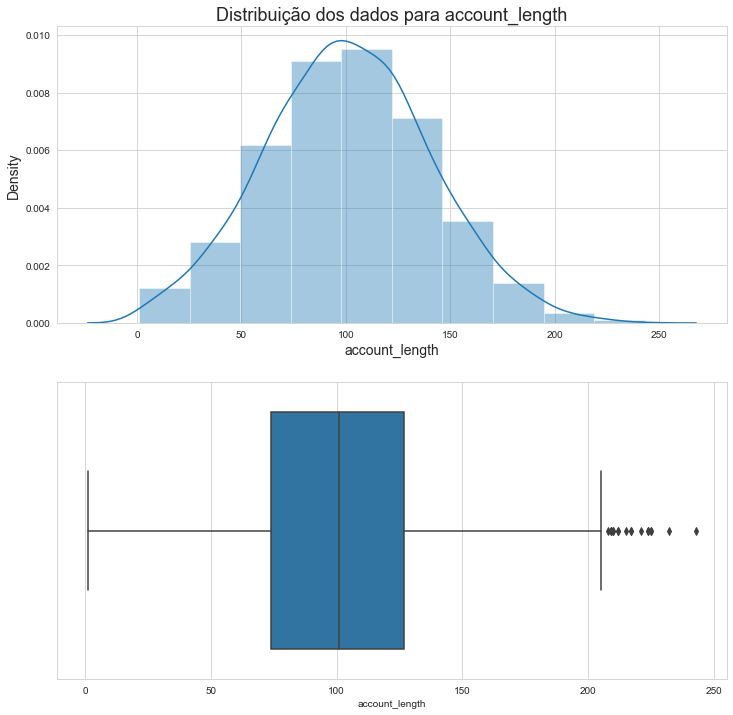

In [56]:
# account_length

find_distribution_outliers("account_length")

**Observações:**
- Os dados apresentam uma distribuição normal, ou seja, tem média e mediana próximas;
- A variável tem outliers acima do limite superior;

Limites de Outliers para total_day_calls:
Q1 = 87.0
Q3 = 114.0
IQR = 27.0
low_outliers = 46.5
high_outliers = 154.5


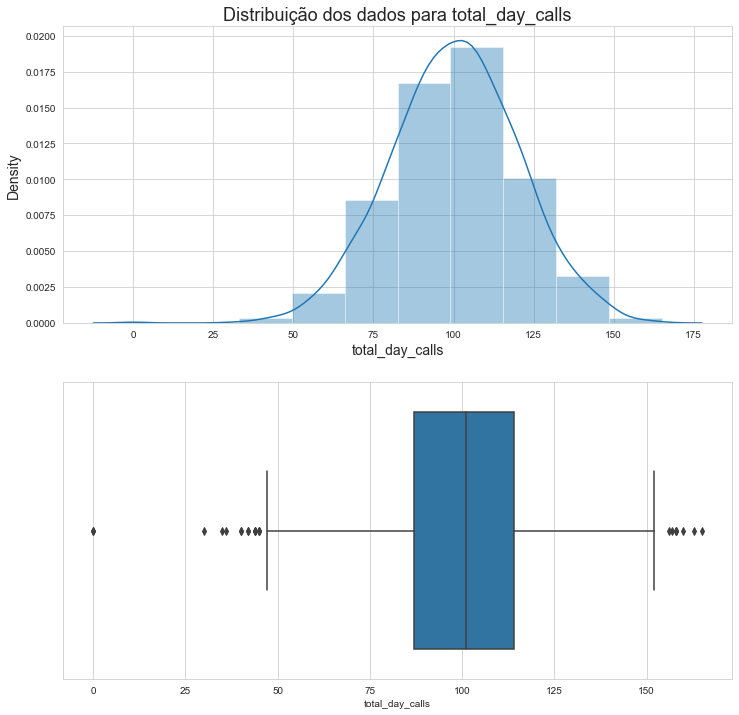

In [57]:
# total_day_calls

find_distribution_outliers("total_day_calls")

**Observações:**
- Dados seguem uma distribuição normal;
- Apresentam outliers abaixo do limite inferior e acima do limite superior.

Limites de Outliers para total_day_minutes:
Q1 = 143.7
Q3 = 216.4
IQR = 72.70000000000002
low_outliers = 34.64999999999996
high_outliers = 325.45000000000005


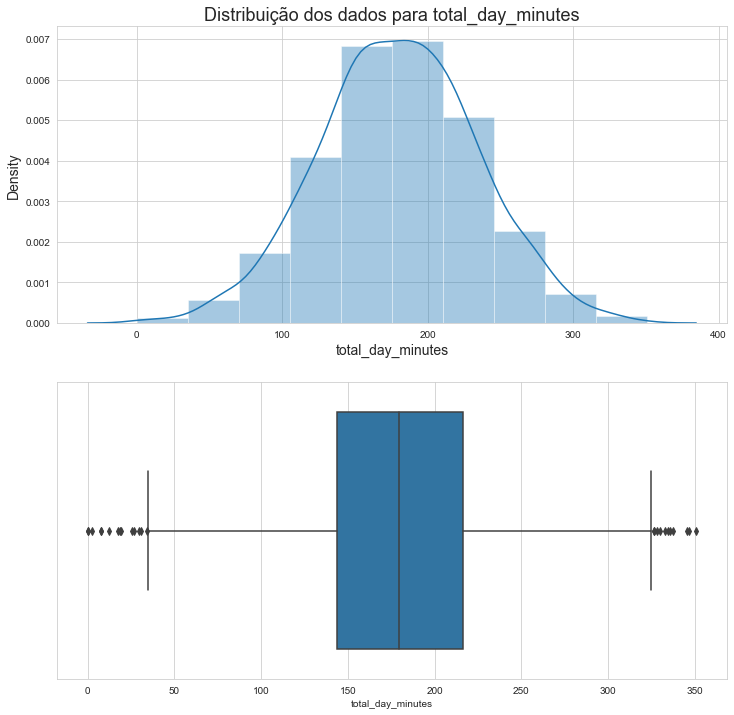

In [58]:
# total_day_minutes

find_distribution_outliers("total_day_minutes")

**Observações:**
- Dados seguem uma tendência de distribuição normal;
- Apresentam outliers abaixo do limite inferior e acima do limite superior.

Limites de Outliers para total_day_charge:
Q1 = 24.43
Q3 = 36.79
IQR = 12.36
low_outliers = 5.890000000000001
high_outliers = 55.33


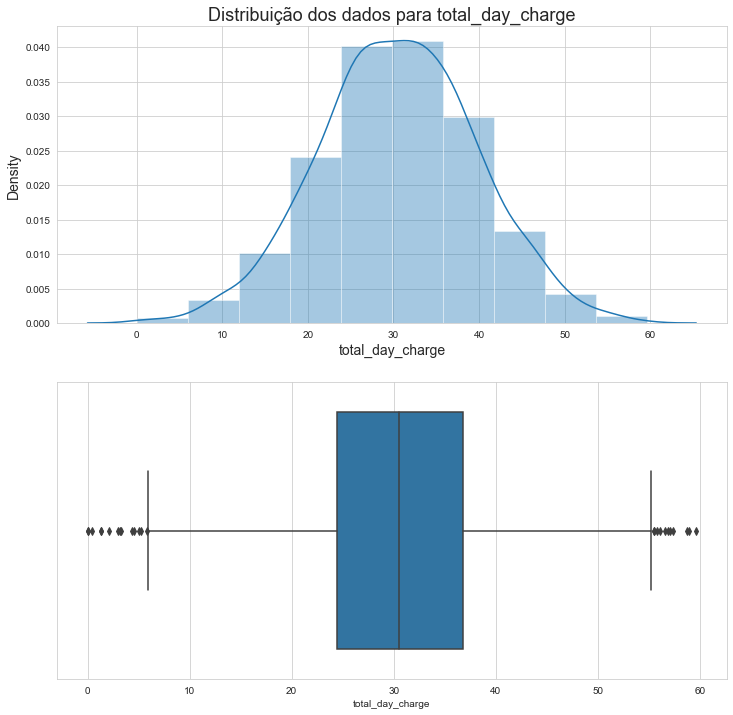

In [59]:
# total_day_charge

find_distribution_outliers("total_day_charge")

**Observações:**
- Dados seguem uma tendência de distribuição normal;
- Apresentam outliers abaixo do limite inferior e acima do limite superior.

Limites de Outliers para total_eve_calls:
Q1 = 87.0
Q3 = 114.0
IQR = 27.0
low_outliers = 46.5
high_outliers = 154.5


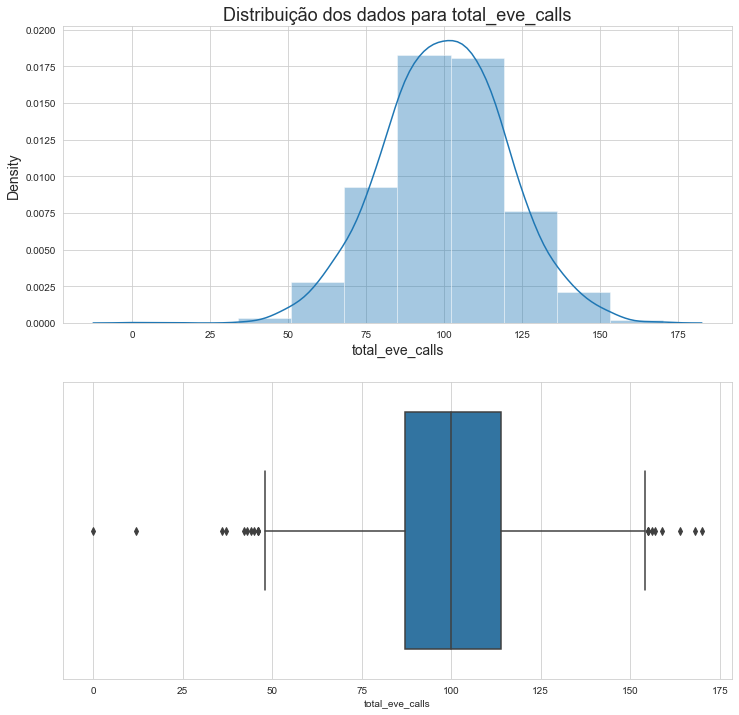

In [60]:
# total_eve_calls

find_distribution_outliers("total_eve_calls")

**Observações:**
- Dados seguem uma distribuição normal;
- Apresentam outliers abaixo do limite inferior e acima do limite superior.

Limites de Outliers para total_eve_minutes:
Q1 = 166.6
Q3 = 235.3
IQR = 68.70000000000002
low_outliers = 63.54999999999997
high_outliers = 338.35


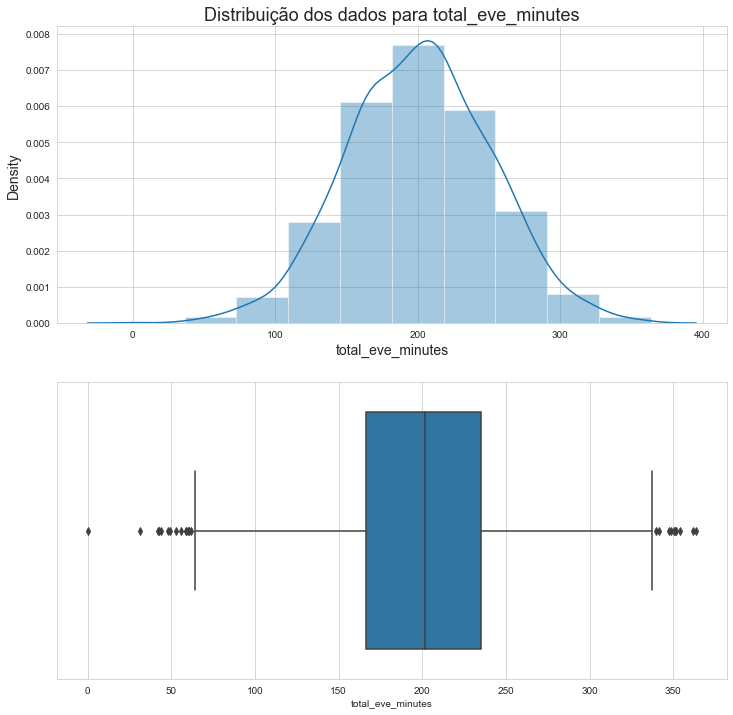

In [61]:
# total_eve_minutes

find_distribution_outliers("total_eve_minutes")

**Observações:**
- Dados seguem uma tendência de distribuição normal;
- Apresentam outliers abaixo do limite inferior e acima do limite superior.

Limites de Outliers para total_eve_charge:
Q1 = 14.16
Q3 = 20.0
IQR = 5.84
low_outliers = 5.4
high_outliers = 28.759999999999998


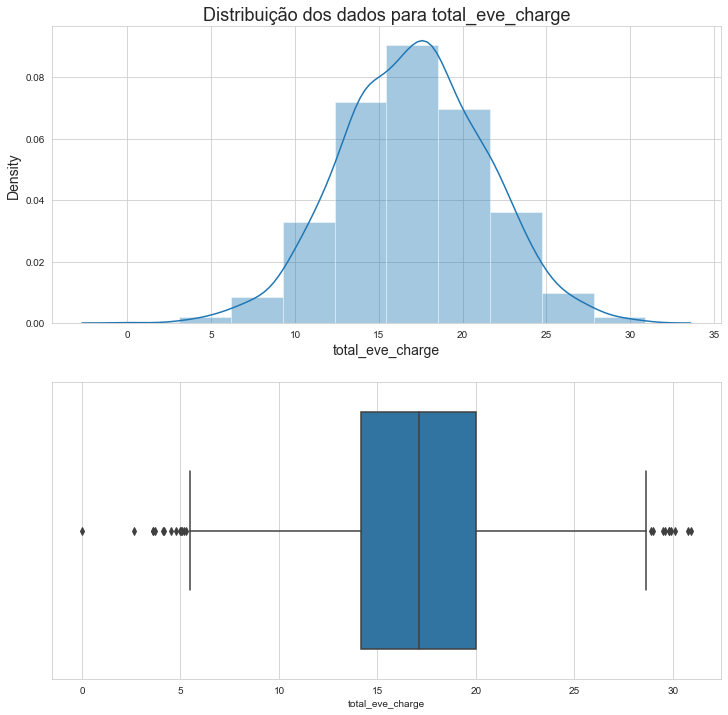

In [62]:
# total_eve_charge

find_distribution_outliers("total_eve_charge")

**Observações:**
- Dados seguem uma tendência de distribuição normal;
- Apresentam outliers abaixo do limite inferior e acima do limite superior.

Limites de Outliers para total_night_calls:
Q1 = 87.0
Q3 = 113.0
IQR = 26.0
low_outliers = 48.0
high_outliers = 152.0


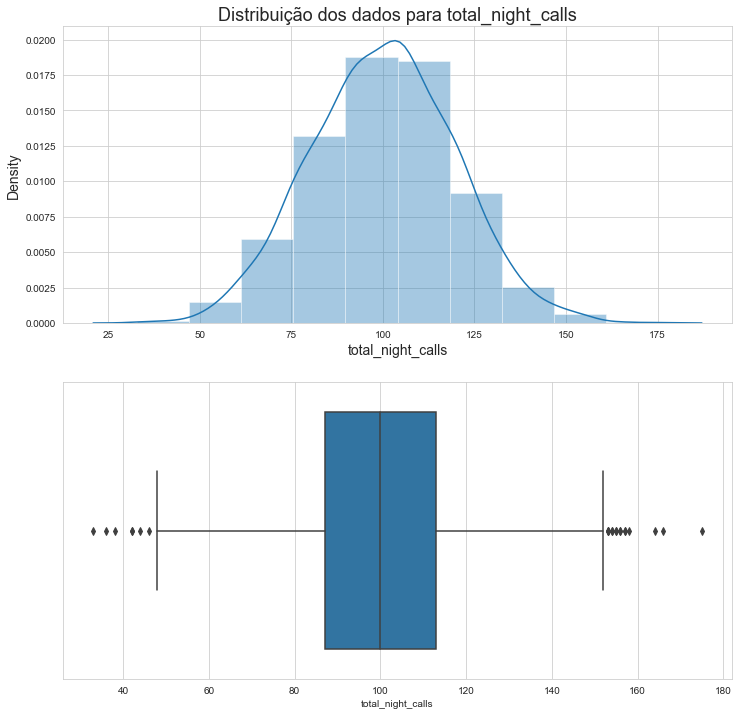

In [63]:
# total_night_calls

find_distribution_outliers("total_night_calls")

Limites de Outliers para total_night_minutes:
Q1 = 167.0
Q3 = 235.3
IQR = 68.30000000000001
low_outliers = 64.54999999999998
high_outliers = 337.75


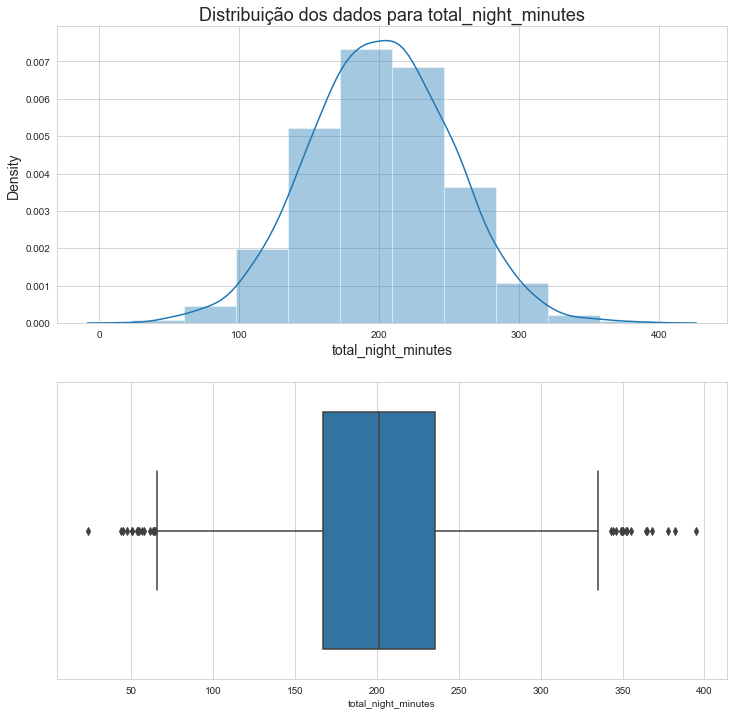

In [64]:
# total_night_minutes

find_distribution_outliers("total_night_minutes")

Limites de Outliers para total_night_charge:
Q1 = 7.52
Q3 = 10.59
IQR = 3.0700000000000003
low_outliers = 2.914999999999999
high_outliers = 15.195


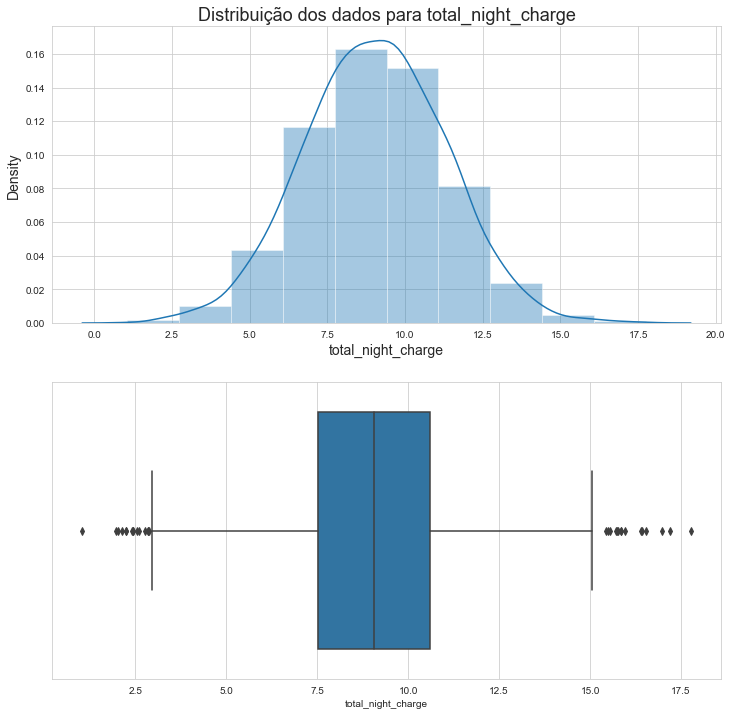

In [65]:
# total_night_charge

find_distribution_outliers("total_night_charge")

**Observações:**
- Dados seguem uma distribuição normal;
- Apresentam outliers inferiores e superiores.

Limites de Outliers para total_intl_calls:
Q1 = 3.0
Q3 = 6.0
IQR = 3.0
low_outliers = -1.5
high_outliers = 10.5


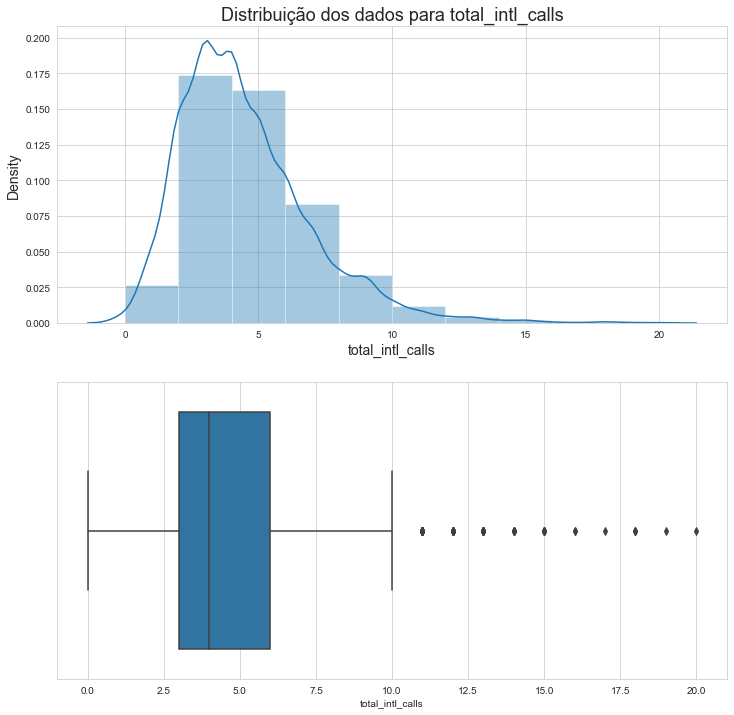

In [66]:
# total_intl_calls

find_distribution_outliers("total_intl_calls")

**Observações:**
- Dados seguem uma distribuição exponencial, ou seja, grande parte dos registros são tem valores mais baixos, enquant os mais altos possuem menor frequência;
- Apresentam outliers acima do limite superior.

Limites de Outliers para total_intl_minutes:
Q1 = 8.5
Q3 = 12.1
IQR = 3.5999999999999996
low_outliers = 3.1000000000000005
high_outliers = 17.5


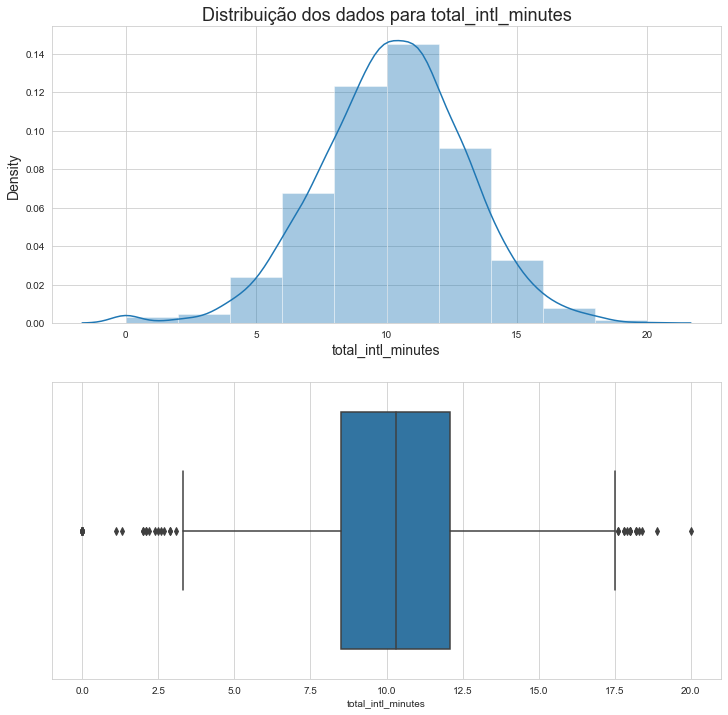

In [67]:
# total_intl_minutes

find_distribution_outliers("total_intl_minutes")

**Observações:**
- Dados seguem uma distribuição normal;
- Apresentam outliers abaixo do limite inferior e acima do limite superior.

Limites de Outliers para total_intl_charge:
Q1 = 2.3
Q3 = 3.27
IQR = 0.9700000000000002
low_outliers = 0.8449999999999995
high_outliers = 4.7250000000000005


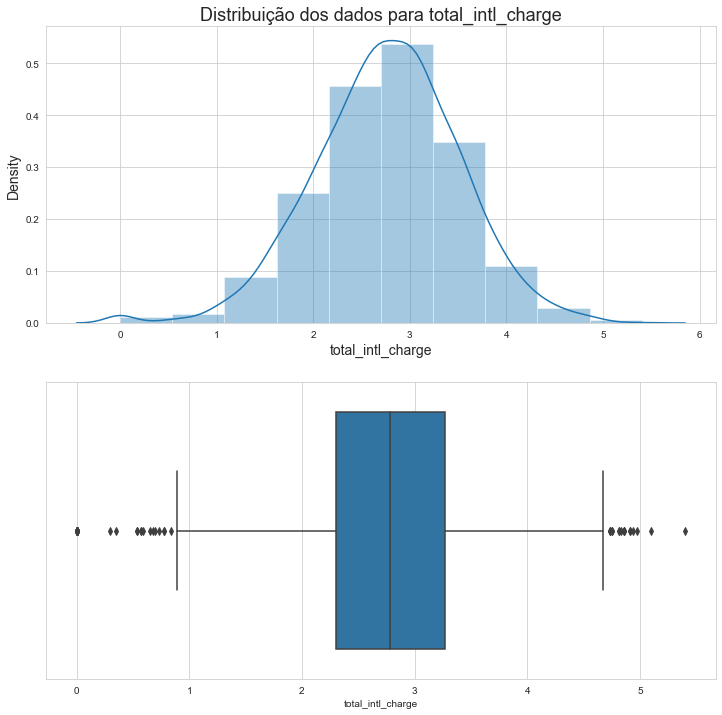

In [68]:
# total_intl_charge

find_distribution_outliers("total_intl_charge")

**Observações:**
- Dados seguem uma distribuição normal;
- Apresentam outliers abaixo do limite inferior e acima do limite superior.

## 2.4.2 Variáveis Categóricas

In [69]:
train_df_pandas[categorical_var].nunique()

churn                  2
international_plan     2
state                 51
voice_mail_plan        2
dtype: int64

Aqui é possível perceber que **churn, international_plan e voice_mail_plan** são categorias binárias, ou seja, apresentam apenas sim ou não. Já a variável **state** apresenta 51 valores distintos, um para cada estado dos EUA.

In [70]:
categorical_var

['churn', 'international_plan', 'state', 'voice_mail_plan']

In [71]:
numerical_var

['account_length',
 'area_code',
 'id_num',
 'number_customer_service_calls',
 'number_vmail_messages',
 'total_day_calls',
 'total_day_charge',
 'total_day_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_eve_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'total_intl_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_night_minutes']

In [72]:
df1 = train_df_pandas[["state", "number_customer_service_calls"]].groupby("state")["number_customer_service_calls"].sum().reset_index()
df1 = df1.sort_values("number_customer_service_calls", ascending = False)


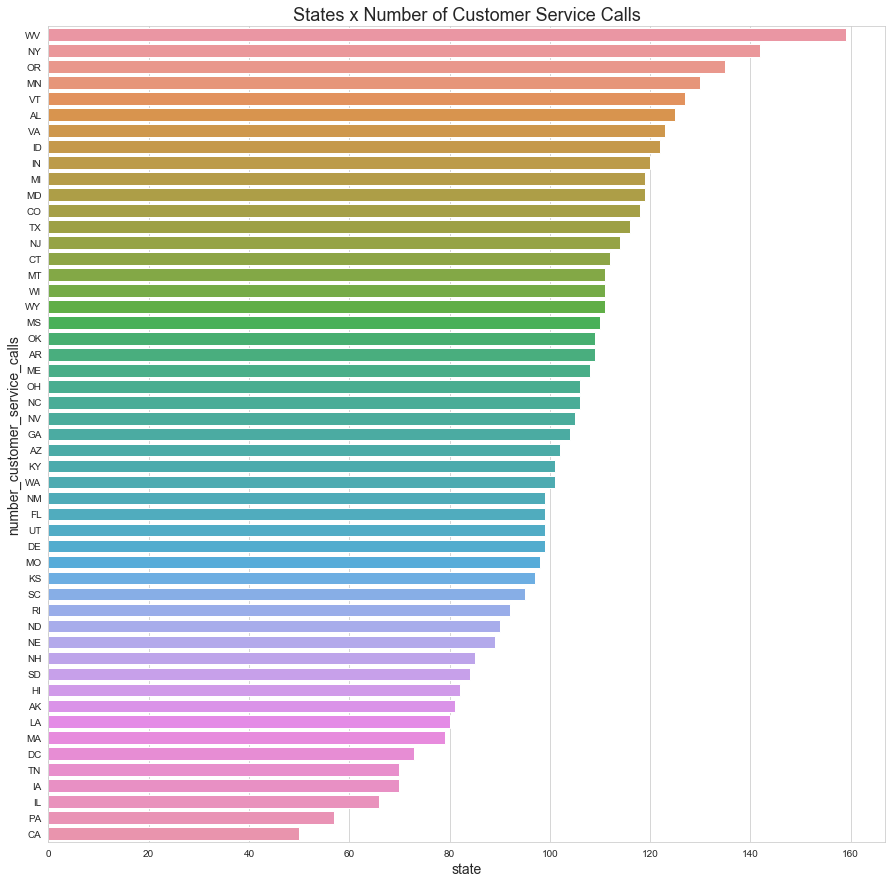

In [73]:
plt.figure(1, figsize=(15,15))
ax = sns.barplot(x = 'number_customer_service_calls', y = 'state', data=df1, orient = "h")
set_plots_features(ax, 'States x Number of Customer Service Calls', 'state', 'number_customer_service_calls')

**Observações:**
- Os estados que mais possuem ligação para o serviço de call center é WV, NY, OR, MN, VT.

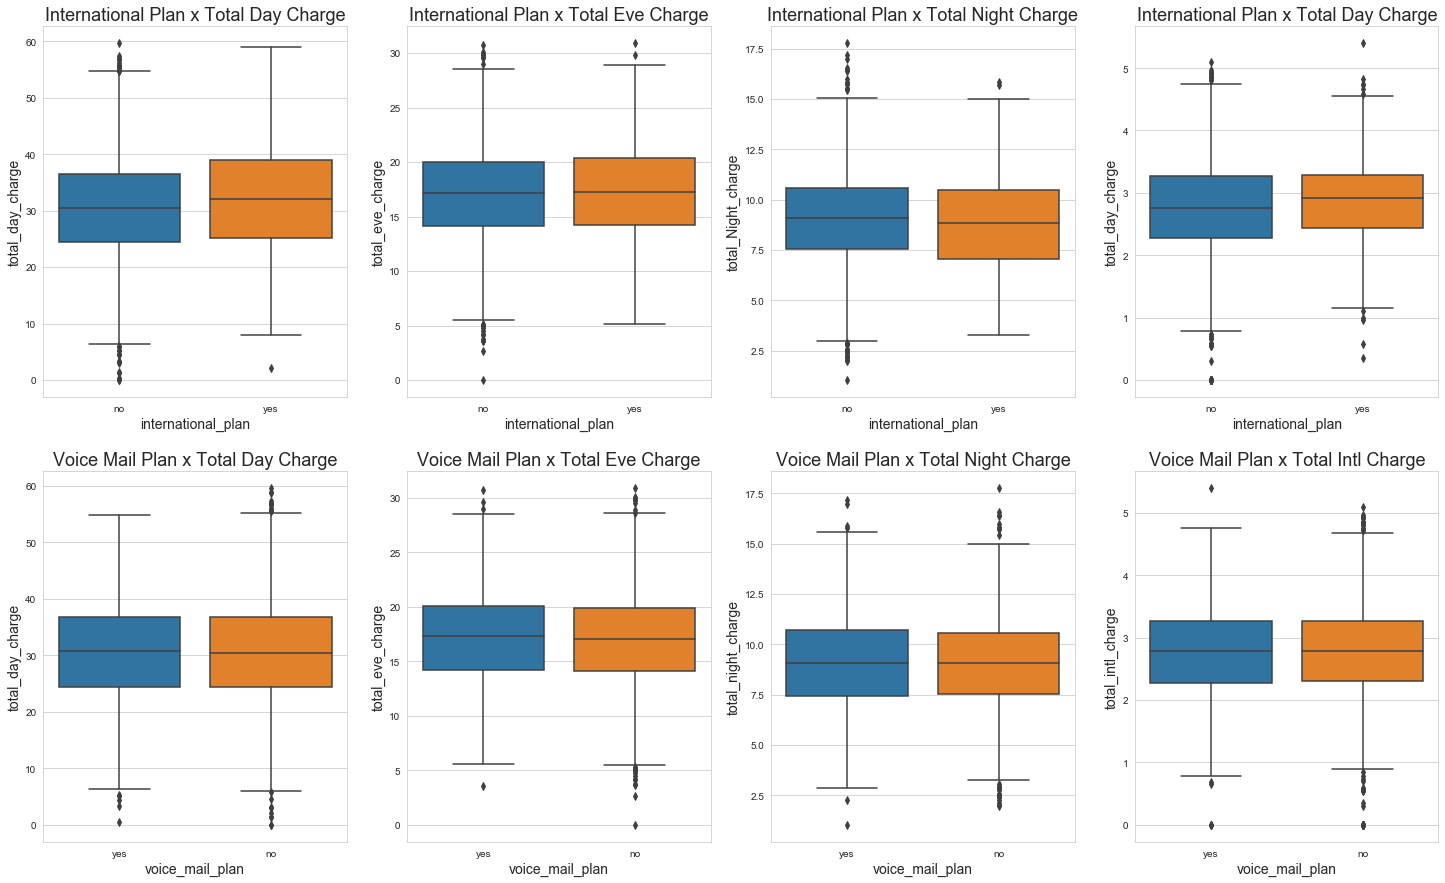

In [74]:
fig, ax = plt.subplots()

ax.figure.set_size_inches(25,15)

plt.subplot(2,4,1)
ax = sns.boxplot(x = 'international_plan', y = 'total_day_charge', data=train_df_pandas)
set_plots_features(ax, 'International Plan x Total Day Charge', 'international_plan', 'total_day_charge')


plt.subplot(2,4,2)
ax = sns.boxplot(x = 'international_plan', y = 'total_eve_charge', data=train_df_pandas)
set_plots_features(ax, 'International Plan x Total Eve Charge', 'international_plan', 'total_eve_charge')


plt.subplot(2,4,3)
ax = sns.boxplot(x = 'international_plan', y = 'total_night_charge', data=train_df_pandas)
set_plots_features(ax, 'International Plan x Total Night Charge', 'international_plan', 'total_Night_charge')


plt.subplot(2,4,4)
ax = sns.boxplot(x = 'international_plan', y = 'total_intl_charge', data=train_df_pandas)
set_plots_features(ax, 'International Plan x Total Day Charge', 'international_plan', 'total_day_charge')



plt.subplot(2,4,5)
ax = sns.boxplot(x = 'voice_mail_plan', y = 'total_day_charge', data=train_df_pandas)
set_plots_features(ax, 'Voice Mail Plan x Total Day Charge', 'voice_mail_plan', 'total_day_charge')


plt.subplot(2,4,6)
ax = sns.boxplot(x = 'voice_mail_plan', y = 'total_eve_charge', data=train_df_pandas)
set_plots_features(ax, 'Voice Mail Plan x Total Eve Charge', 'voice_mail_plan', 'total_eve_charge')


plt.subplot(2,4,7)
ax = sns.boxplot(x = 'voice_mail_plan', y = 'total_night_charge', data=train_df_pandas)
set_plots_features(ax, 'Voice Mail Plan x Total Night Charge', 'voice_mail_plan', 'total_night_charge')


plt.subplot(2,4,8)
ax = sns.boxplot(x = 'voice_mail_plan', y = 'total_intl_charge', data=train_df_pandas)
set_plots_features(ax, 'Voice Mail Plan x Total Intl Charge', 'voice_mail_plan', 'total_intl_charge')



**Observações:**

- A categoria de plano internacional acrescenta muito pouco na cobrança das chamadas;
- A categoria de possui um plano de correio de voz não tem inflûencia alguma sobre o preço das cobranças.

## 3.0 Mapa de Hipóteses

![Mental_Map](images/mental_map_n.PNG)

Para criação das hipóteses, foi elaborado um mapa mental atuando com a variável target **churn** como filtro central e as demais features são avaliadas como características que podem levar à um cliente abandonar a operadora de telefonia. 

## 3.1 Criando Hipóteses

**H1**: Quem tem plano internacional tem mais risco de abandonar a operadora;

**H2**: Quem tem caixa postal tem menos risco de abandonar a operadora;

**H3**: Estados com mais imigrantes possuem mais risco de abandonar a operadora;

**H4:** Clientes com maior risco de churn falam menos que quem tem menos risco, na média;

**H5**: Quem é cliente acima de 100 dias tem menos risco de abandonar a operadora;

**H6**: Pessoas que estão em churn possuem o preço do minuto maior do que os que não estão;

**H7**:Quem tem plano internacional e usa pouco possui mais chance de abandonar a operadora;

**H8**: Quem tem plano internacional paga menos que quem não tem, e consequentemente, tem menor risco de deixar a operadora;

**H9**: Quem liga mais vezes para o call center, tem mais riscos de churn.

**H10**: Clientes com perfil de falar mais tempo durante o dia tem mais probabilidade de sair da operadora; 

**H11**: O preço do minuto durante o dia é mais caro que a noite e a madrugada; 

**H12**: Clientes que estão em churn possuem um gasto maior no dia do que a noite e a madrugada. 

## 4.0 Feature Engineering

Na etapa de feature engineering, vamos criar variáveis capazes de ajudar na análise exploratória dos dados, agrupando algumas features e somando outras para saber o total durante o dia completo. Essa etapa é muito importante não apenas para gerar insights sobre o problema de negócio, mas também encontrar as características necessárias para o modelo tomar as melhores decisões.

### 4.0.1 Total de ligações durante 24h

In [75]:
train_df_pandas["total_calls"] = train_df_pandas["total_day_calls"] + train_df_pandas["total_eve_calls"] + train_df_pandas["total_night_calls"] 

### 4.0.2 Total de minutos falados durante 24h

In [76]:
train_df_pandas["total_minutes"] = train_df_pandas["total_day_minutes"] + train_df_pandas["total_eve_minutes"] + train_df_pandas["total_night_minutes"] 

### 4.0.3 Custo de ligações durante 24h

In [77]:
train_df_pandas["total_charge"] = train_df_pandas["total_day_charge"] + train_df_pandas["total_eve_charge"] + train_df_pandas["total_night_charge"] 

### 4.0.4 Preço do minuto

In [78]:
train_df_pandas["minute_price"] = train_df_pandas["total_charge"] / train_df_pandas["total_minutes"] # Quanto ela gasta por minuto

### 4.0.5 Minutos por chamada

In [79]:
train_df_pandas["minutes_calls"] = train_df_pandas["total_minutes"] / train_df_pandas["total_calls"] # Quanto ela fala por chamada

### 4.0.6 Minutos por chamada internacional

In [80]:
train_df_pandas["intl_calls_minutes"] = train_df_pandas["total_intl_minutes"] / train_df_pandas["total_intl_calls"] # Quanto ela fala por chamada internacional

### 4.0.7 Preço do minuto em chamadas internacionais

In [81]:
train_df_pandas["intl_minute_price"] = train_df_pandas["total_intl_charge"] / train_df_pandas["total_intl_minutes"] # Quanto ela gasta por minuto

### 4.0.8 Minutos por chamada durante o dia

In [82]:
train_df_pandas["minute_price_day"] = train_df_pandas["total_day_charge"] / train_df_pandas["total_day_minutes"] # Quanto ela gasta por minuto

### 4.0.9 Minutos por chamada durante a noite

In [83]:
train_df_pandas["minute_price_eve"] = train_df_pandas["total_eve_charge"] / train_df_pandas["total_eve_minutes"] # Quanto ela gasta por minuto

### 4.0.10 Minutos por chamada durante a madrugada

In [84]:
train_df_pandas["minute_price_night"] = train_df_pandas["total_night_charge"] / train_df_pandas["total_night_minutes"] # Quanto ela gasta por minuto

### 4.0.8 Se reside ou não em um estado top5 com maior número de imigrantes nos EUA

In [85]:
top5_foreign_states = ["CA", "NY", "NJ", "FL", "NV"]

train_df_pandas["is_top5_foreign_state"] = train_df_pandas["state"].apply(lambda state: "yes" if state in top5_foreign_states else "no")

## 4.1 Filtragem de Variáveis

Diversas variáveis numéricas possuem um número muito grande de outliers, conforme evidenciado na seção **2.4.1.2**. Dessa forma, restringimos o range de valores a fim de filtrar essas variáveis e diminuir a chance dessas possuirem algum tipo de erro de medição, causa de muitos outliers. Para fazer as modificações, utiliza-se novamente um DataFrame do PySpark.

In [86]:
trainDF2 = spark.createDataFrame(train_df_pandas)

In [87]:
# Filtro superior para a variavel account length devido aos outliers superiores
trainDF2 = trainDF2.filter(trainDF2.account_length < 210)

In [88]:
# Filtro superior para a variavel total_day_calls devido aos outliers superiores e inferiores
trainDF2 = trainDF2.filter(trainDF2.total_day_calls > 46).filter(trainDF2.total_day_calls < 160)

In [89]:
# Filtro superior para a variavel total_day_minutes devido aos outliers superiores e inferiores
trainDF2 = trainDF2.filter(trainDF2.total_day_minutes > 35).filter(trainDF2.total_day_minutes < 330)

In [90]:
# Filtro superior para a variavel total_day_charge devido aos outliers superiores e inferiores
trainDF2 = trainDF2.filter(trainDF2.total_day_charge > 5.5).filter(trainDF2.total_day_charge < 60)

In [91]:
# Filtro superior para a variavel total_eve_calls devido aos outliers superiores e inferiores
trainDF2 = trainDF2.filter(trainDF2.total_eve_calls > 46).filter(trainDF2.total_eve_calls < 160)

In [92]:
# Filtro superior para a variavel total_eve_minutes devido aos outliers superiores e inferiores
trainDF2 = trainDF2.filter(trainDF2.total_eve_minutes > 65).filter(trainDF2.total_eve_minutes < 340)

In [93]:
# Filtro superior para a variavel total_eve_charge devido aos outliers superiores e inferiores
trainDF2 = trainDF2.filter(trainDF2.total_eve_charge > 5).filter(trainDF2.total_eve_charge < 30)

In [94]:
# Filtro superior para a variavel total_night_calls devido aos outliers superiores e inferiores
trainDF2 = trainDF2.filter(trainDF2.total_night_calls > 48).filter(trainDF2.total_night_calls < 160)

In [95]:
# Filtro superior para a variavel total_night_minutes devido aos outliers superiores e inferiores
trainDF2 = trainDF2.filter(trainDF2.total_night_minutes > 64).filter(trainDF2.total_night_minutes < 340)

In [96]:
# Filtro superior para a variavel total_night_charge devido aos outliers superiores e inferiores
trainDF2 = trainDF2.filter(trainDF2.total_night_charge > 3).filter(trainDF2.total_night_charge < 16)

In [97]:
# Filtro superior para a variavel total_intl_calls devido aos outliers superiores
trainDF2 = trainDF2.filter(trainDF2.total_intl_calls < 12)

In [98]:
# Filtro superior para a variavel total_intl_minutes devido aos outliers superiores e inferiores
trainDF2 = trainDF2.filter(trainDF2.total_intl_minutes > 3).filter(trainDF2.total_intl_minutes < 17.5)

In [99]:
# Filtro superior para a variavel total_intl_charge devido aos outliers superiores e inferiores
trainDF2 = trainDF2.filter(trainDF2.total_intl_charge > 0.8).filter(trainDF2.total_intl_charge < 4.7)

### 4.3 Tamanho do Novo Dataset

In [100]:
print("Dimensão dos dados de treino: ({row}, {column})".format(row = trainDF2.count(), column = len(trainDF2.columns)))

Dimensão dos dados de treino: (3106, 32)


## 5.0 Análise Exploratória dos Dados

Na etapa de análise exploratória de dados, busca-se encontrar quais variáveis são mais importantes para o modelo, as relações de cada uma com a varíavel target e também entre features. Além disso, é nessa etapa que agrega-se valor ao negócio, por meio das validações de hipóteses criadas na seção **3.1**.

A EDA é dividida em 3 etapas: univariada, bivariada e multivariada.

In [101]:
# Novamente, converte-se o PySpark DF para um Pandas para facilitar a utilização das funções
train_df_pandas2 = trainDF2.toPandas()

In [102]:
train_df_pandas2.head()

,account_length,area_code,churn,id_num,international_plan,number_customer_service_calls,number_vmail_messages,state,total_day_calls,total_day_charge,total_day_minutes,total_eve_calls,total_eve_charge,total_eve_minutes,total_intl_calls,total_intl_charge,total_intl_minutes,total_night_calls,total_night_charge,total_night_minutes,voice_mail_plan,total_calls,total_minutes,total_charge,minute_price,minutes_calls,intl_calls_minutes,intl_minute_price,minute_price_day,minute_price_eve,minute_price_night,is_top5_foreign_state
0,128,415,no,1,no,1,25,KS,110,45.07,265.1,99,16.78,197.4,3,2.70,10.0,91,11.01,244.7,yes,300,707.2,72.86,0.103026,2.357333,3.333333,0.270000,0.170011,0.085005,0.044994,no
1,107,415,no,2,no,1,26,OH,123,27.47,161.6,103,16.62,195.5,3,3.70,13.7,103,11.45,254.4,yes,329,611.5,55.54,0.090826,1.858663,4.566667,0.270073,0.169988,0.085013,0.045008,no
2,137,415,no,3,no,0,0,NJ,114,41.38,243.4,110,10.30,121.2,5,3.29,12.2,104,7.32,162.6,no,328,527.2,59.00,0.111912,1.607317,2.440000,0.269672,0.170008,0.084983,0.045018,yes
3,75,415,no,5,yes,3,0,OK,113,28.34,166.7,122,12.61,148.3,3,2.73,10.1,121,8.41,186.9,no,356,501.9,49.36,0.098346,1.409831,3.366667,0.270297,0.170006,0.085030,0.044997,no
4,118,510,no,6,yes,0,0,AL,98,37.98,223.4,101,18.75,220.6,6,1.70,6.3,118,9.18,203.9,no,317,647.9,65.91,0.101729,2.043849,1.050000,0.269841,0.170009,0.084995,0.045022,no


### 5.1 Análise Univariada

### 5.1.1 Variável Target

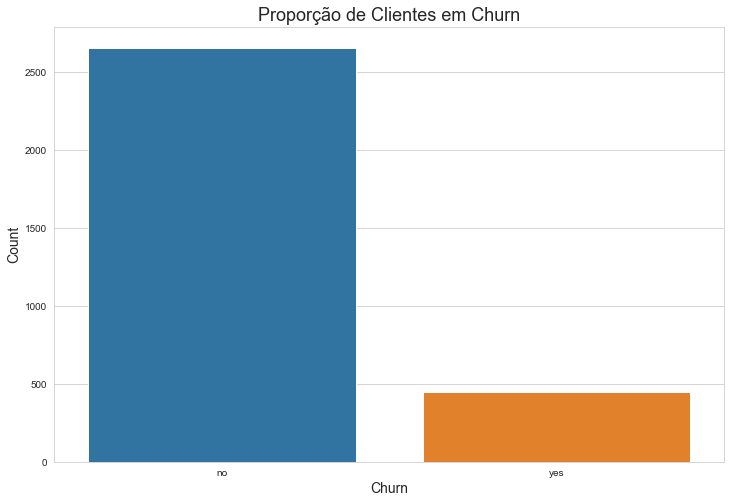

In [103]:
fig, ax = plt.subplots()

# Figure Size
ax.figure.set_size_inches(12,8)


ax = sns.countplot(x = 'churn', data = train_df_pandas2)
set_plots_features(ax, "Proporção de Clientes em Churn", "Churn", "Count")

In [104]:
train_df_pandas2["churn"].value_counts(normalize = True)

no     0.856085
yes    0.143915
Name: churn, dtype: float64

**Observação**:
A taxa de Churn nos dados de treino chegam a 14.39%, a qual é considerada muito superior à uma taxa normal, que é próxima de 5%.

### 5.1.2 Variáveis Numéricas

In [105]:
numerical_var.remove("id_num")

C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F5E64A43C8>,
      dtype=object)

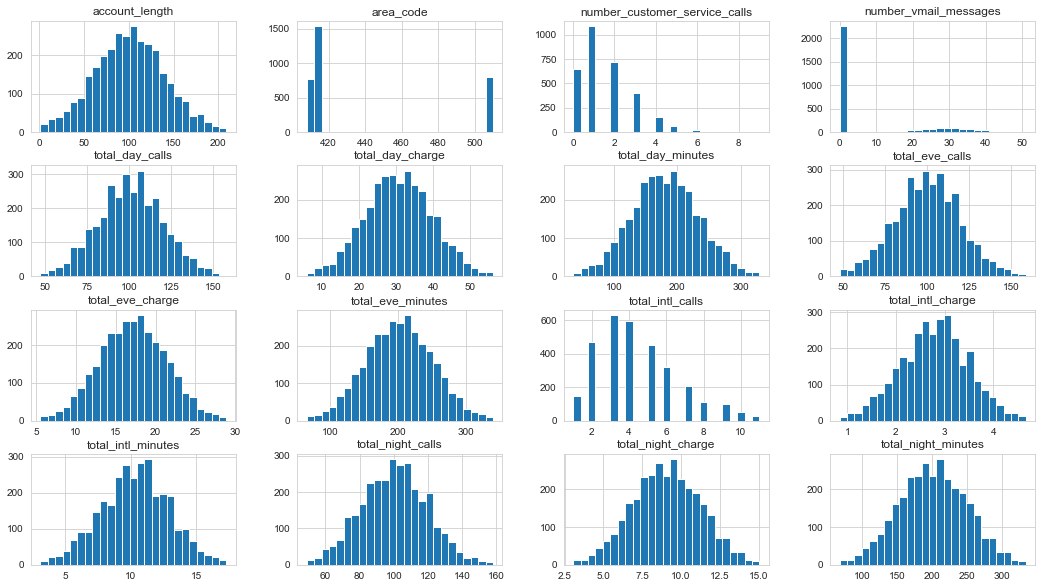

In [106]:
fig = plt.figure(figsize=(18,10))

ax = fig.gca()
    
train_df_pandas2[numerical_var].hist(ax = ax, bins = 25)

**Observações:**

- É possível observar que a maioria dos usuários da operadora são clientes dentro de um periódo entre 50 e 150 dias;
- O maior número de reclamações no call center é de 1 ligação, porém, ainda há muitos usuários com 2 ou mais chamadas;
- A concentração de mensagens no correio de voz é abaixo de 10, porém, há alguns usuários entre 20 e 40 mensagens;
- Os dados de ligações possuem uma distribuição muito próximos da normal, com exceção das ligações internacionais que apresenta uma tendência de ser uma distribuição exponencial.

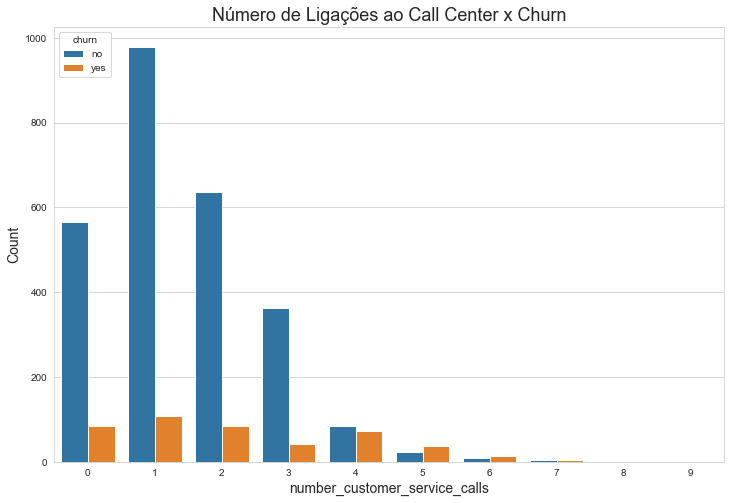

In [107]:
fig = plt.figure(figsize=(12,8))

ax = fig.gca()

ax = sns.countplot(x="number_customer_service_calls", hue = "churn", data = train_df_pandas2)
set_plots_features(ax, "Número de Ligações ao Call Center x Churn", "number_customer_service_calls", "Count")

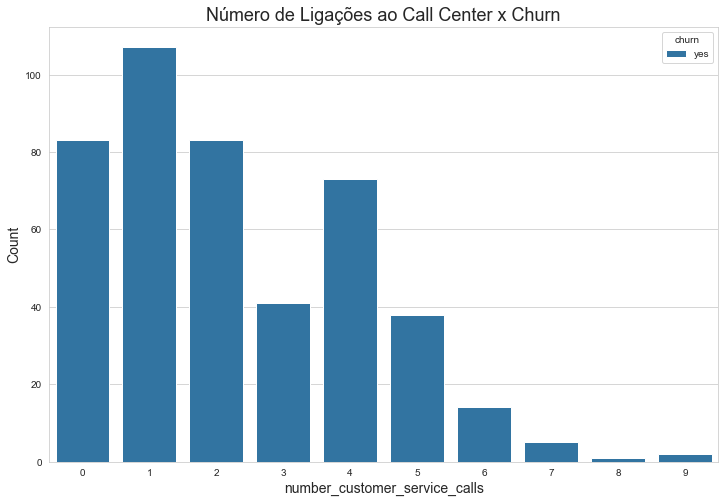

In [108]:
df_aux = train_df_pandas2[train_df_pandas2["churn"] == "yes"]

fig = plt.figure(figsize=(12,8))

ax = fig.gca()

ax = sns.countplot(x="number_customer_service_calls", hue = "churn", data = df_aux)
set_plots_features(ax, "Número de Ligações ao Call Center x Churn", "number_customer_service_calls", "Count")

**Observação**:Clientes que não estão em Churn reclamam em média 2x, enquanto o número de reclamações de quem está em Churn não apresenta uma média estável, visto que há um bom número de reclamações em 1 ou 2x, porém, há outro pico em 4x. 

### 5.1.3 Variáveis Categóricas

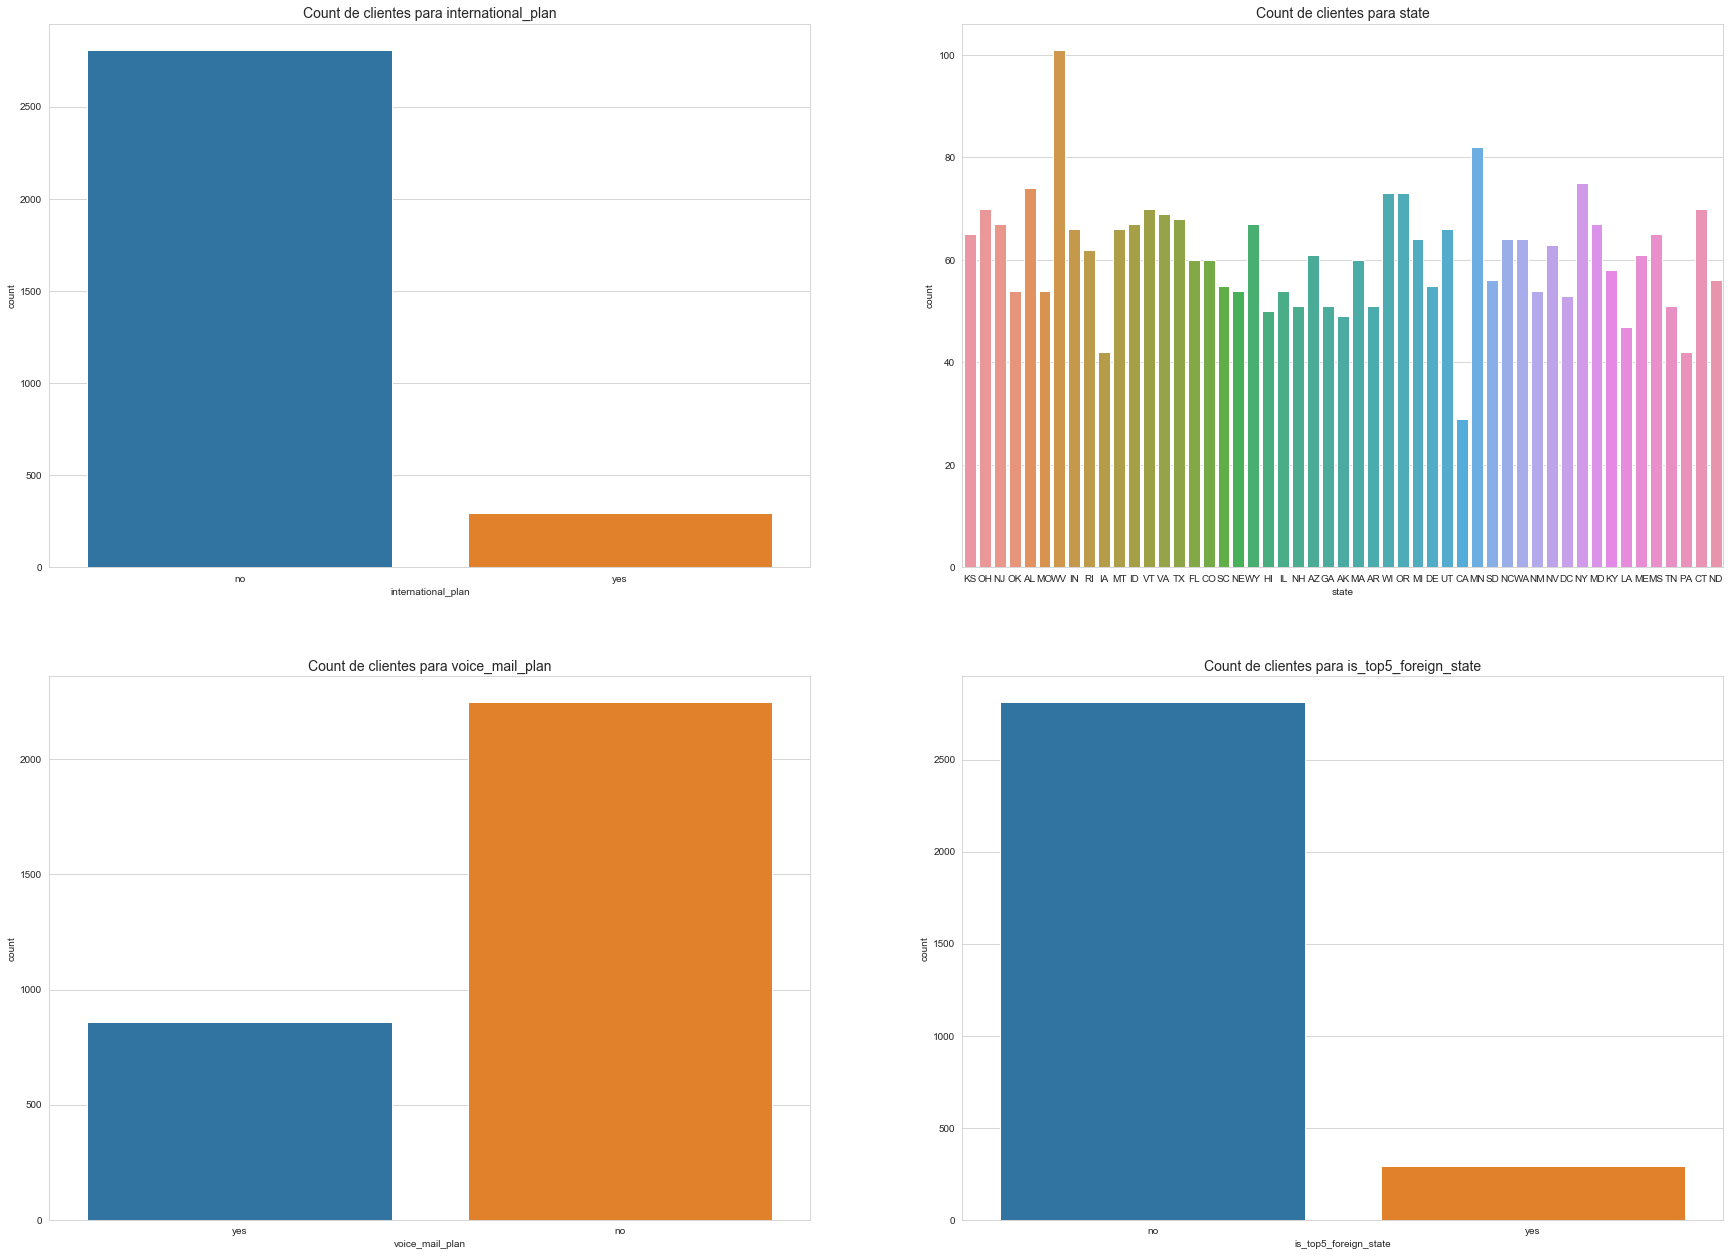

In [109]:
# sets plot size
plt.figure(figsize=(30,22))

# sets the initial plot position
n = 1

for cat in categorical_var[1:] + ["is_top5_foreign_state"]:
    plt.subplot(2,2,n)
    _ = sns.countplot(train_df_pandas2[cat])
    plt.title("Count de clientes para " + cat, fontsize=14)
    
    n = n+1

**Observação**:

- A maior parte dos clientes não possuem plano internacional;
- O número de clientes por estado é consideravelmente distribuída;
- A maior parte dos clientes não possuem correio de voz;
- A maior parte dos clientes não vivem em estados povoados por imigrantes.

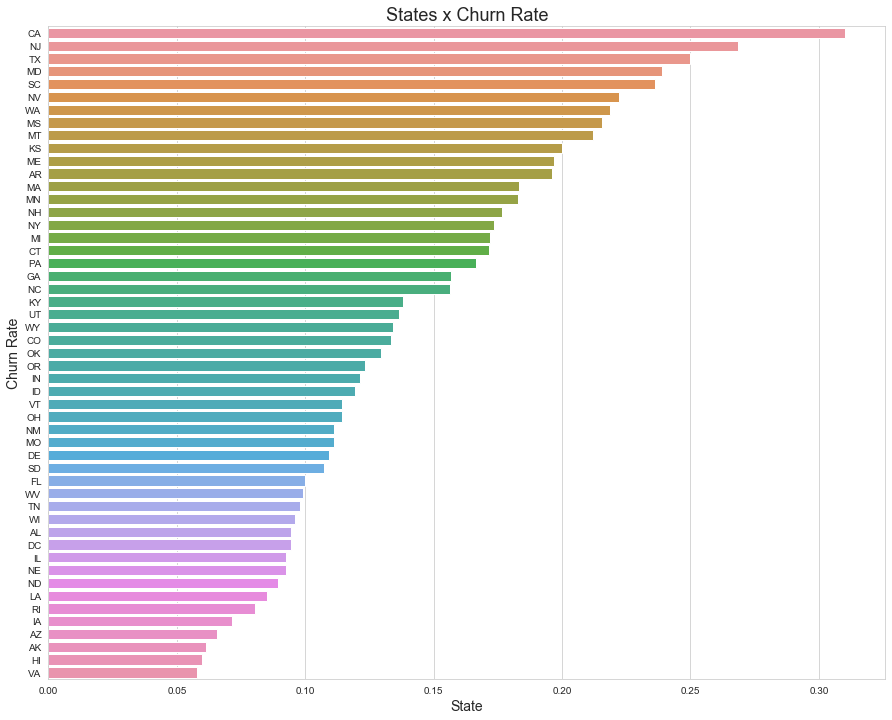

In [110]:
# sets plot size
plt.figure(figsize=(15,12))

df_states = train_df_pandas2.groupby("state")["churn"].value_counts(normalize=True)
churn_state = pd.DataFrame(df_states[df_states.index.isin(['yes'], level=1)]).droplevel(level=1).sort_values("churn", ascending=False)

ax = sns.barplot(x = 'churn', y = churn_state.index, data=churn_state, orient = "h")
set_plots_features(ax, 'States x Churn Rate', 'State', 'Churn Rate')


**Observações:**

- A maioria dos clientes não possuem plano internacional (apenas 9.59%);
- A operadora possui mais clientes em West Virginia (3.25%), Minessota (2.64%) e Nova York (2.41%);
- Mais de 70% dos usuários não possuem correio de voz;
- Apenas 9.46% dos usuários são dos estados com mais imigrantes dos EUA.
- Muitos estados estão com um Churn Rate altíssimo, como a Califórnia, New Jersey, Texas...

## 5.2 Análise Bivariada

É nessa etapa de EDA que respondemos as hipóteses geradas:

### 5.2.1 Validando Hipóteses

**H1:** Quem tem plano internacional tem mais risco de abandonar a operadora;

**VERDADE**: Quem tem plano internacional apresenta mais riscos para abandonar a operadora.

In [111]:
df_aux_int = train_df_pandas2[train_df_pandas2["international_plan"] == "yes"]
df_aux_no_int = train_df_pandas2[train_df_pandas2["international_plan"] == "no"]

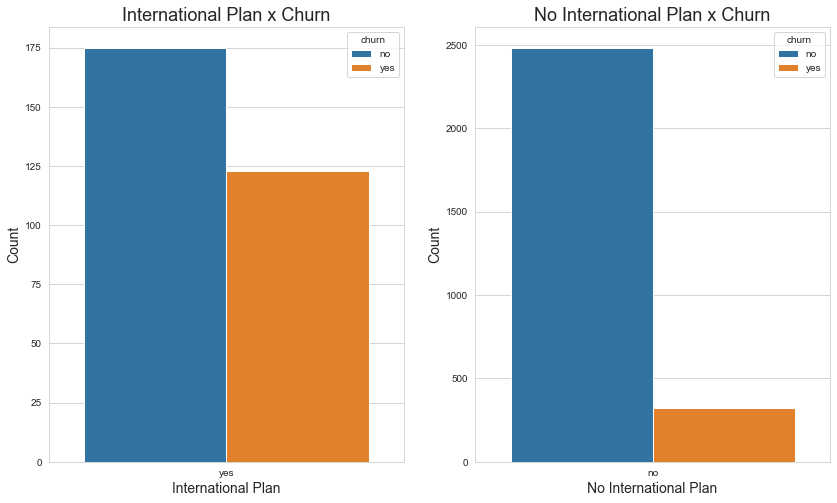

In [112]:
fig, ax = plt.subplots()

ax.figure.set_size_inches(14,8)

plt.subplot(1,2,1)
ax = sns.countplot(x = "international_plan", hue = "churn", data = df_aux_int)
set_plots_features(ax, "International Plan x Churn", "International Plan", "Count")

plt.subplot(1,2,2)
ax = sns.countplot(x = "international_plan", hue = "churn", data = df_aux_no_int)
set_plots_features(ax, "No International Plan x Churn", "No International Plan", "Count")

**H2:** Quem tem caixa postal tem menos risco de abandonar a operadora;

**VERDADE**: Quem possui caixa postal tem menos chance de abandonar a operadora.

In [113]:
df_aux_cp = train_df_pandas2[train_df_pandas2["voice_mail_plan"] == "yes"]
df_aux_no_cp = train_df_pandas2[train_df_pandas2["voice_mail_plan"] == "no"]

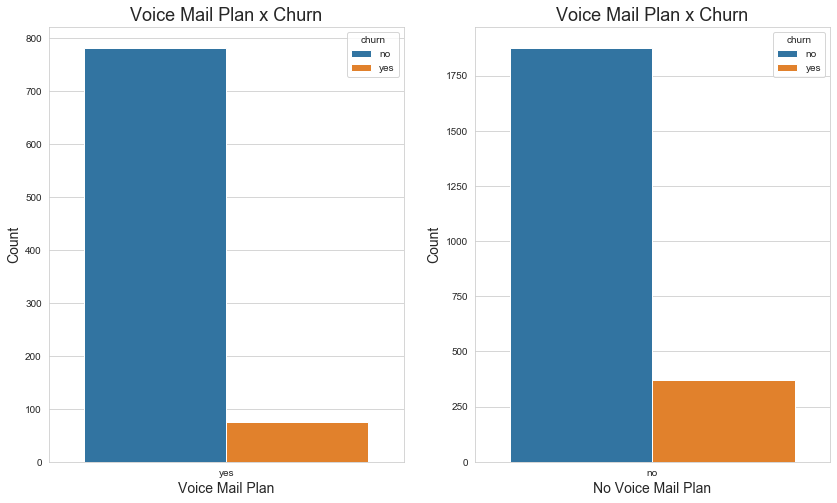

In [114]:
fig, ax = plt.subplots()

ax.figure.set_size_inches(14,8)

plt.subplot(1,2,1)
ax = sns.countplot(x = "voice_mail_plan", hue = "churn", data = df_aux_cp)
set_plots_features(ax, "Voice Mail Plan x Churn", "Voice Mail Plan", "Count")

plt.subplot(1,2,2)
ax = sns.countplot(x = "voice_mail_plan", hue = "churn", data = df_aux_no_cp)
set_plots_features(ax, "Voice Mail Plan x Churn", "No Voice Mail Plan", "Count")

**H3:** Estados com mais imigrantes possuem mais risco de abandonar a operadora;

**VERDADE**: Estados com mais imigrantes tendem a ter mais saídas da operadora.

In [115]:
df_aux_im = train_df_pandas2[train_df_pandas2["is_top5_foreign_state"] == "yes"]
df_aux_no_im = train_df_pandas2[train_df_pandas2["is_top5_foreign_state"] == "no"]

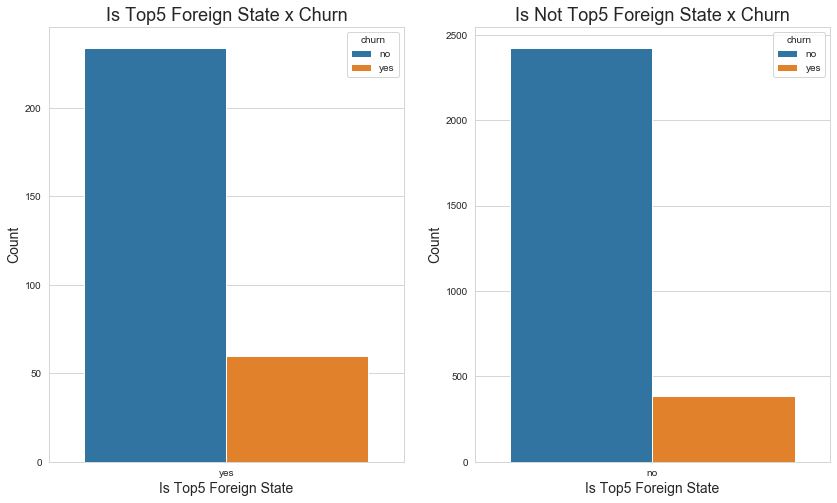

In [116]:
fig, ax = plt.subplots()

ax.figure.set_size_inches(14,8)

plt.subplot(1,2,1)
ax = sns.countplot(x = "is_top5_foreign_state", hue = "churn", data = df_aux_im)
set_plots_features(ax, "Is Top5 Foreign State x Churn", "Is Top5 Foreign State", "Count")

plt.subplot(1,2,2)
ax = sns.countplot(x = "is_top5_foreign_state", hue = "churn", data = df_aux_no_im)
set_plots_features(ax, "Is Not Top5 Foreign State x Churn", "Is Top5 Foreign State", "Count")

**H4:** Clientes com maior risco de churn falam menos que quem tem menos risco, na média.

**FALSO**: Clientes em churn falam mais do que quem não está em churn.

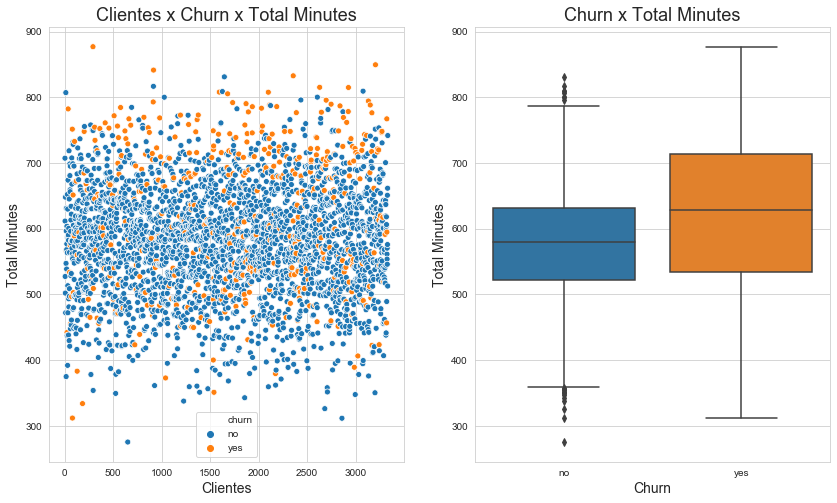

In [465]:
fig, ax = plt.subplots()

ax.figure.set_size_inches(14,8)


plt.subplot(1,2,1)
ax = sns.scatterplot(x = "id_num", hue = 'churn', y = "total_minutes", data = train_df_pandas2)
set_plots_features(ax, "Clientes x Churn x Total Minutes", "Clientes", "Total Minutes")

plt.subplot(1,2,2)
ax = sns.boxplot(x = "churn", y = "total_minutes", data = train_df_pandas2)
set_plots_features(ax, "Churn x Total Minutes", "Churn", "Total Minutes")


**H5**: Quem é cliente acima de 100 dias tem menos risco de abandonar a operadora;

**VERDADE**: Clientes com account_length maior que 100 dias tem menos riscos de abandonar a operadora.

In [119]:
df_aux_acc = train_df_pandas2[train_df_pandas2["account_length"] > 100]
round(df_aux_acc["churn"].value_counts(normalize=True), 4)*100

no     85.32
yes    14.68
Name: churn, dtype: float64

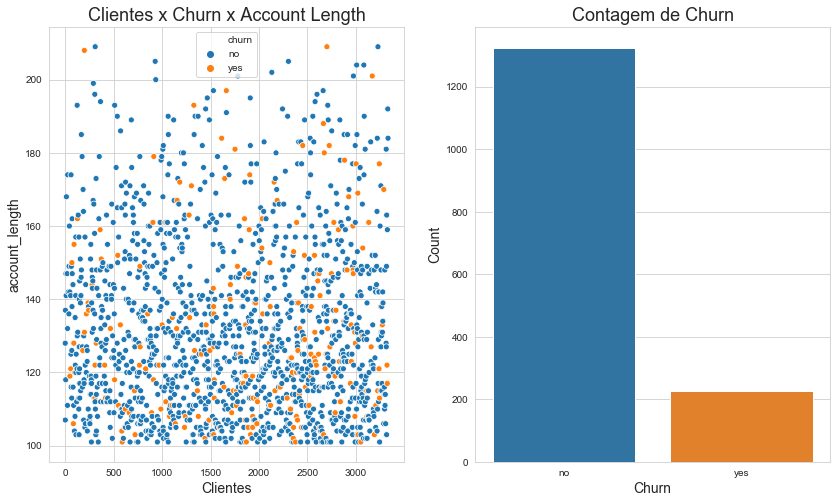

In [120]:
fig, ax = plt.subplots()

# Figure Size
ax.figure.set_size_inches(14,8)

# Scatter Plot
plt.subplot(1,2,1)
ax = sns.scatterplot(x = 'id_num', hue='churn', y= 'account_length', data=df_aux_acc)
set_plots_features(ax, 'Clientes x Churn x Account Length', 'Clientes', 'account_length')

plt.subplot(1,2,2)
ax = sns.countplot(x = 'churn', data=df_aux_acc)
set_plots_features(ax, 'Contagem de Churn', 'Churn', 'Count')



**H6**: Pessoas que estão em churn possuem o preço do minuto maior do que os que não estão;

**FALSO**: O preço do minuto pra quem está em churn é ligeiramente maior, porém, não é suficiente para dizer que influencia no risco.

In [466]:
df_aux_churn = train_df_pandas2[train_df_pandas2["churn"] == "yes"]
df_aux_no_churn = train_df_pandas2[train_df_pandas2["churn"] == "no"]

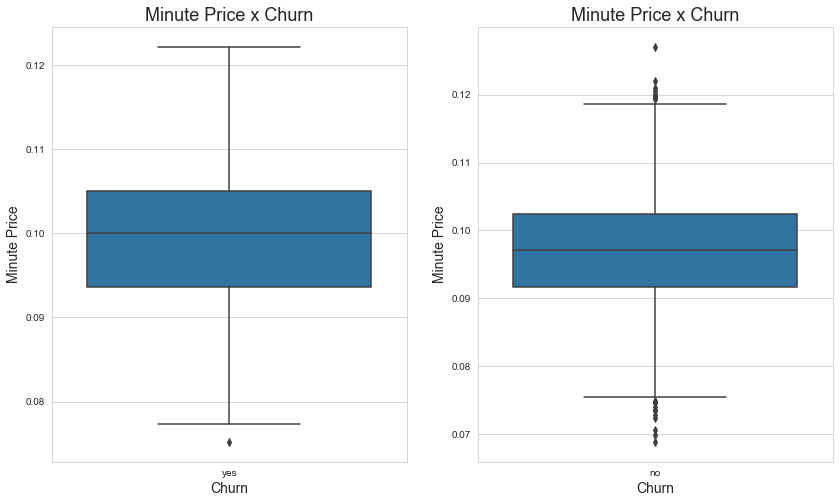

In [121]:
fig, ax = plt.subplots()

ax.figure.set_size_inches(14,8)

plt.subplot(1,2,1)
ax = sns.boxplot(x = "churn", y = "minute_price", data = df_aux_churn)
set_plots_features(ax, "Minute Price x Churn", "Churn", "Minute Price")

plt.subplot(1,2,2)
ax = sns.boxplot(x = "churn", y = "minute_price", data = df_aux_no_churn)
set_plots_features(ax, "Minute Price x Churn", "Churn", "Minute Price")

**H7**:Quem tem plano internacional e usa pouco (menos que 4 ligações) possui mais chance de abandonar a operadora;

**VERDADE**: Quem possui plano internacional e utiliza menos que 4 vezes, possui quase o dobro de chance de sair da operadora.

In [122]:
df_aux_intl = train_df_pandas2[(train_df_pandas2["international_plan"] == "yes") & (train_df_pandas2["total_intl_calls"] < 4)]

In [123]:
round(df_aux_intl["churn"].value_counts(normalize=True),4)*100

yes    60.8
no     39.2
Name: churn, dtype: float64

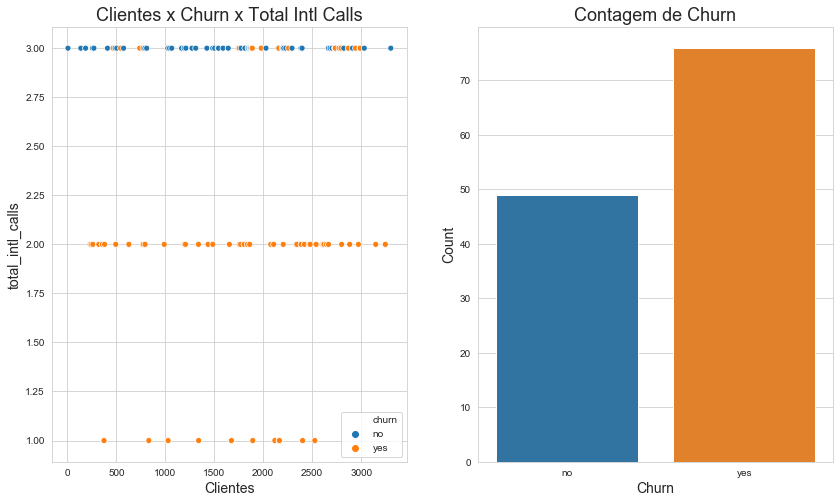

In [124]:
fig, ax = plt.subplots()

# Figure Size
ax.figure.set_size_inches(14,8)

# Scatter Plot
plt.subplot(1,2,1)
ax = sns.scatterplot(x = 'id_num', hue='churn', y= 'total_intl_calls', data=df_aux_intl)
set_plots_features(ax, 'Clientes x Churn x Total Intl Calls', 'Clientes', 'total_intl_calls')

plt.subplot(1,2,2)
ax = sns.countplot(x = 'churn', data=df_aux_intl)
set_plots_features(ax, 'Contagem de Churn', 'Churn', 'Count')



**H8**: Quem tem plano internacional paga menos que quem não tem, e consequentemente, tem menor risco de deixar a operadora;

**FALSO**: Realmente quem possui o plano internacional paga menos o minuto da ligação internacional, entretanto, a diferença é em uma ordem muito baixa a ponto de afirmar que essa hipótese é verdadeira. 

In [125]:
df_aux_intl = train_df_pandas2[(train_df_pandas2["international_plan"] == "yes")]

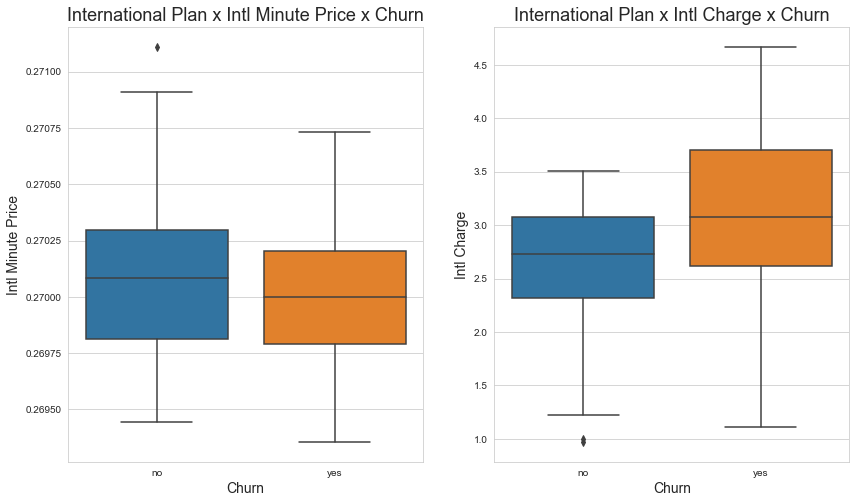

In [126]:
fig, ax = plt.subplots()

# Figure Size
ax.figure.set_size_inches(14,8)

plt.subplot(1,2,1)
ax = sns.boxplot(x = "churn", y = "intl_minute_price", data = df_aux_intl)
set_plots_features(ax, "International Plan x Intl Minute Price x Churn", "Churn", "Intl Minute Price")

plt.subplot(1,2,2)
ax = sns.boxplot(x = "churn", y = "total_intl_charge", data = df_aux_intl)
set_plots_features(ax, "International Plan x Intl Charge x Churn", "Churn", "Intl Charge")

**H9**: Quem liga mais vezes (mais que 4) para o call center, tem mais riscos de churn.

**VERDADE:** Quem liga mais vezes ao call center tem um risco consideravelmente maior de sair da operadora. Também é possível ver que a proporção de Churn aumenta conforme as ligações também aumentam.

In [127]:
df_aux_customers = train_df_pandas2[train_df_pandas2["number_customer_service_calls"] > 4]

In [128]:
df_aux_customers["churn"].value_counts(normalize=True)

yes    0.625
no     0.375
Name: churn, dtype: float64

In [129]:
df_aux_pivot = train_df_pandas2.groupby(['churn', 'number_customer_service_calls']).size().reset_index().pivot(columns='churn', index='number_customer_service_calls', values=0)
df_aux_pivot.replace(np.nan, 0, inplace = True)

In [130]:
total = []
for pair in df_aux_pivot.values:
    total.append(np.sum(pair))


In [131]:
for idx in df_aux_pivot.index:
    df_aux_pivot.iloc[idx] = 100*df_aux_pivot.iloc[idx] / total[idx]

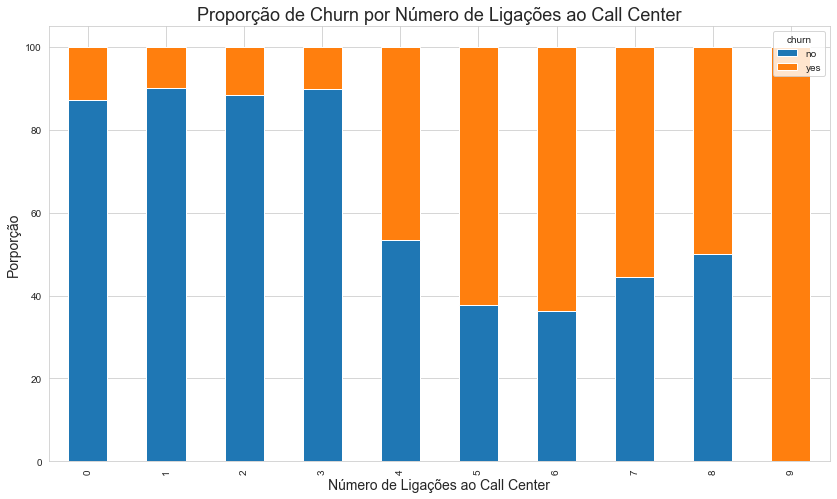

In [132]:

ax = df_aux_pivot.plot(kind='bar', stacked=True, figsize=(14,8))
set_plots_features(ax, 'Proporção de Churn por Número de Ligações ao Call Center', 'Número de Ligações ao Call Center', 'Porporção')

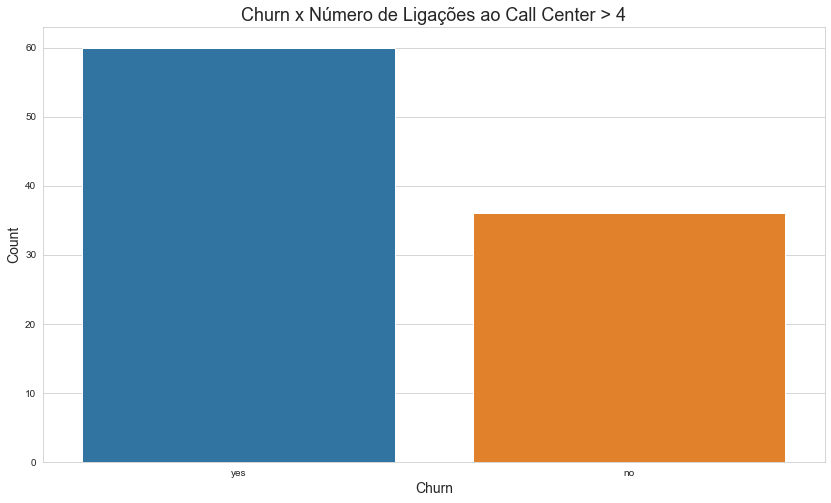

In [133]:

fig, ax = plt.subplots()

# Figure Size
ax.figure.set_size_inches(14,8)


# Count Plot
ax = sns.countplot(x = 'churn', data=df_aux_customers)
set_plots_features(ax, 'Churn x Número de Ligações ao Call Center > 4', 'Churn', 'Count')

**H10**: Clientes com perfil de falar mais tempo durante o dia tem mais probabilidade de sair da operadora; 

**VERDADE**: O churn rate de clientes com perfil "day" é maior que os demais.

In [202]:
def classify_profile(day_min, eve_min, night_min):
    if (day_min > eve_min) and (day_min > night_min):
        return "day"
    elif (eve_min > day_min) and (eve_min > night_min):
        return "eve"
    elif (night_min > day_min) and (night_min > eve_min):
        return "night"
    else:
        return "mixed"
        

In [150]:
train_df_pandas2["profile"] = train_df_pandas2.apply(lambda x: classify_profile(x["total_day_minutes"], x["total_eve_minutes"], x["total_night_minutes"]), axis = 1)

In [168]:
df_aux_profile = train_df_pandas2.groupby("profile")["churn"].value_counts(normalize=True)*100
df_aux_profile = df_aux_profile[df_aux_profile.index.isin(['yes'], level=1)].droplevel(level=1).reset_index()

In [174]:
df_aux_profile_minprice = train_df_pandas2.groupby("profile")["minute_price"].mean().reset_index()

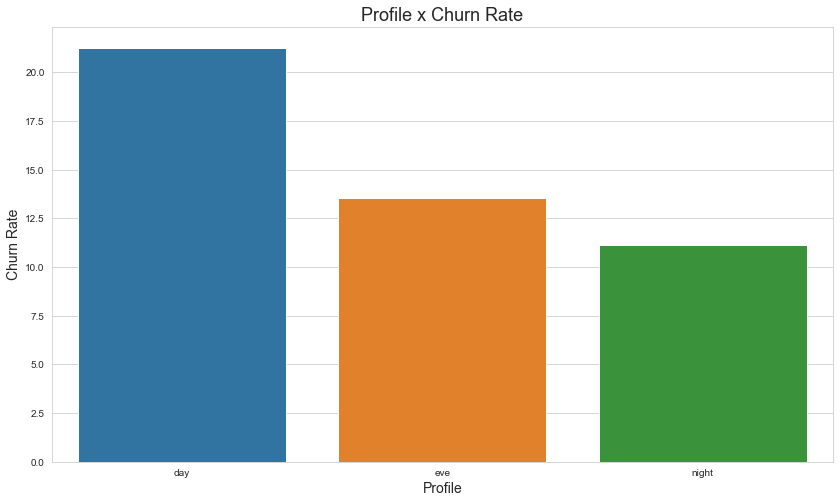

In [178]:
fig, ax = plt.subplots()

# Figure Size
ax.figure.set_size_inches(14,8)


# Bar Plot
ax = sns.barplot(x = 'profile', y = 'churn', data=df_aux_profile)
set_plots_features(ax, 'Profile x Churn Rate', 'Profile', 'Churn Rate')

**H11**: O preço do minuto de quem fala mais durante o dia é mais caro que a noite e a madrugada; 

**VERDADE**: O preço do minuto durante o dia é consideralvemente mais caro do que a noite e na madrugada.

In [191]:
df_aux_day = train_df_pandas2[train_df_pandas2["profile"] == "day"]

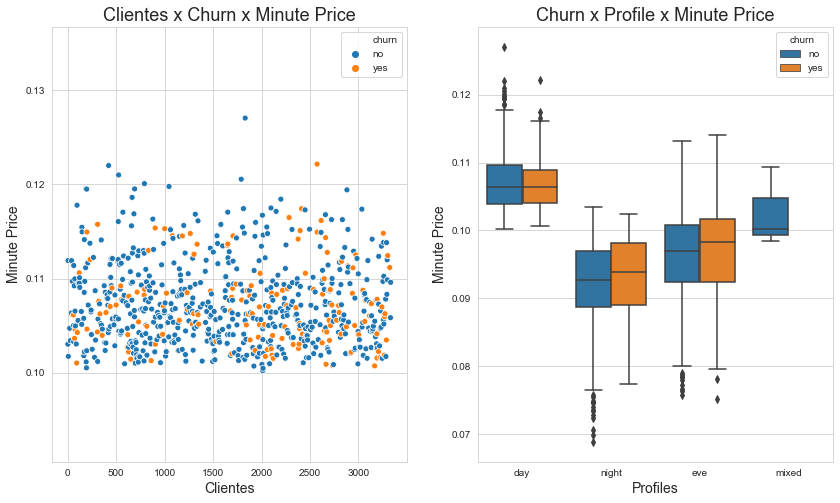

In [198]:
fig, ax = plt.subplots()

# Figure Size
ax.figure.set_size_inches(14,8)

plt.subplot(1,2,1)
ax = sns.scatterplot(x = "id_num", hue = 'churn', y = "minute_price", data = df_aux_day)
set_plots_features(ax, "Clientes x Churn x Minute Price", "Clientes", "Minute Price")


plt.subplot(1,2,2)
ax = sns.boxplot(x = "profile", hue = 'churn', y = "minute_price", data = train_df_pandas2)
set_plots_features(ax, "Churn x Profile x Minute Price", "Profiles", "Minute Price")

**H12**: Clientes que estão em churn possuem um gasto maior no dia do que a noite e a madrugada. 

**VERDADE**: Clientes que gastam mais durante o dia estão com risco de churn muito maior que os demais.

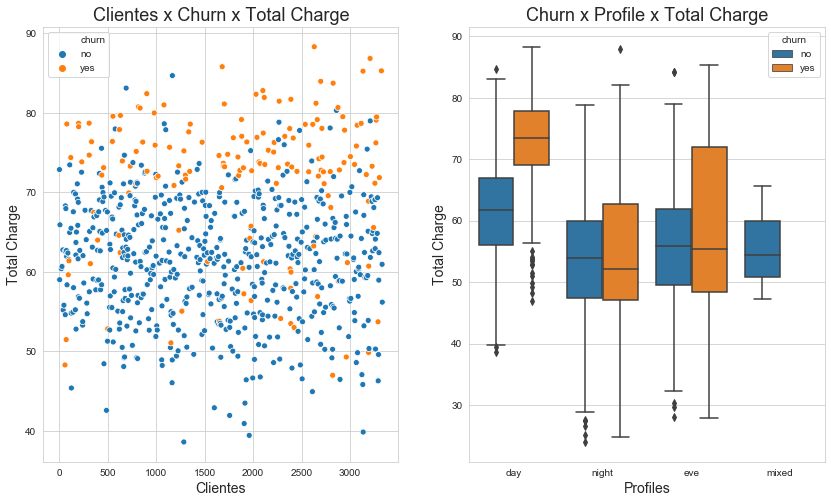

In [201]:
fig, ax = plt.subplots()

# Figure Size
ax.figure.set_size_inches(14,8)

plt.subplot(1,2,1)
ax = sns.scatterplot(x = "id_num", hue = 'churn', y = "total_charge", data = df_aux_day)
set_plots_features(ax, "Clientes x Churn x Total Charge", "Clientes", "Total Charge")


plt.subplot(1,2,2)
ax = sns.boxplot(x = "profile", hue = 'churn', y = "total_charge", data = train_df_pandas2)
set_plots_features(ax, "Churn x Profile x Total Charge", "Profiles", "Total Charge")

### 5.2.2 Resumo das Hipóteses

Resumindo as hipóteses assumidas inicialmente, podemos ver quais são válidas ou não, e a partir disso gerar insights que ajudem o negócio a reduzir a taxa de churn, através de promoções dirigidas ou encontrar um grupo mais favorável ao cancelamento do plano da operadora.

In [203]:
ids = ["H1", "H2", "H3", "H4", "H5", "H6", "H7","H8", "H9", "H10", "H11", "H12"]
desc = ["Quem tem plano internacional tem mais risco de abandonar a operadora",
"Quem tem caixa postal tem menos risco de abandonar a operadora",
"Estados com mais imigrantes possuem mais risco de abandonar a operadora",
"Clientes com maior risco de churn falam menos que quem tem menos risco, na média",
"Quem é cliente acima de 100 dias tem menos risco de abandonar a operadora",
"Pessoas que estão em churn possuem o preço do minuto maior do que os que não estão",
"Quem tem plano internacional e usa pouco possui mais chance de abandonar a operadora",
"Quem tem plano internacional paga menos que quem não tem, e consequentemente, tem menor risco de deixar a operadora",
"Quem liga mais vezes para o call center, tem mais riscos de churn",
"Clientes com perfil de falar mais tempo durante o dia tem mais probabilidade de sair da operadora",
"O preço do minuto durante o dia é mais caro que a noite e a madrugada",
"Clientes que estão em churn possuem um gasto maior no dia do que a noite e a madrugada"      
       ]

status = ["Verdade", "Verdade", "Verdade", "Falso", "Verdade", "Falso", "Verdade", "Falso", "Verdade", "Verdade", "Verdade", "Verdade"]


pd.DataFrame({"Hipótese" : ids,
              "Descrição" : desc,
              "Status" : status}).set_index("Hipótese")

,Descrição,Status
Hipótese,,
H1,Quem tem plano internacional tem mais risco de...,Verdade
H2,Quem tem caixa postal tem menos risco de aband...,Verdade
H3,Estados com mais imigrantes possuem mais risco...,Verdade
H4,Clientes com maior risco de churn falam menos ...,Falso
H5,Quem é cliente acima de 100 dias tem menos ris...,Verdade
H6,Pessoas que estão em churn possuem o preço do ...,Falso
H7,Quem tem plano internacional e usa pouco possu...,Verdade
H8,Quem tem plano internacional paga menos que qu...,Falso
H9,"Quem liga mais vezes para o call center, tem m...",Verdade


## 5.3 Análise Multivariada

### 5.3.1 Variáveis Numéricas

**Cálculo de matriz de correlações**

C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


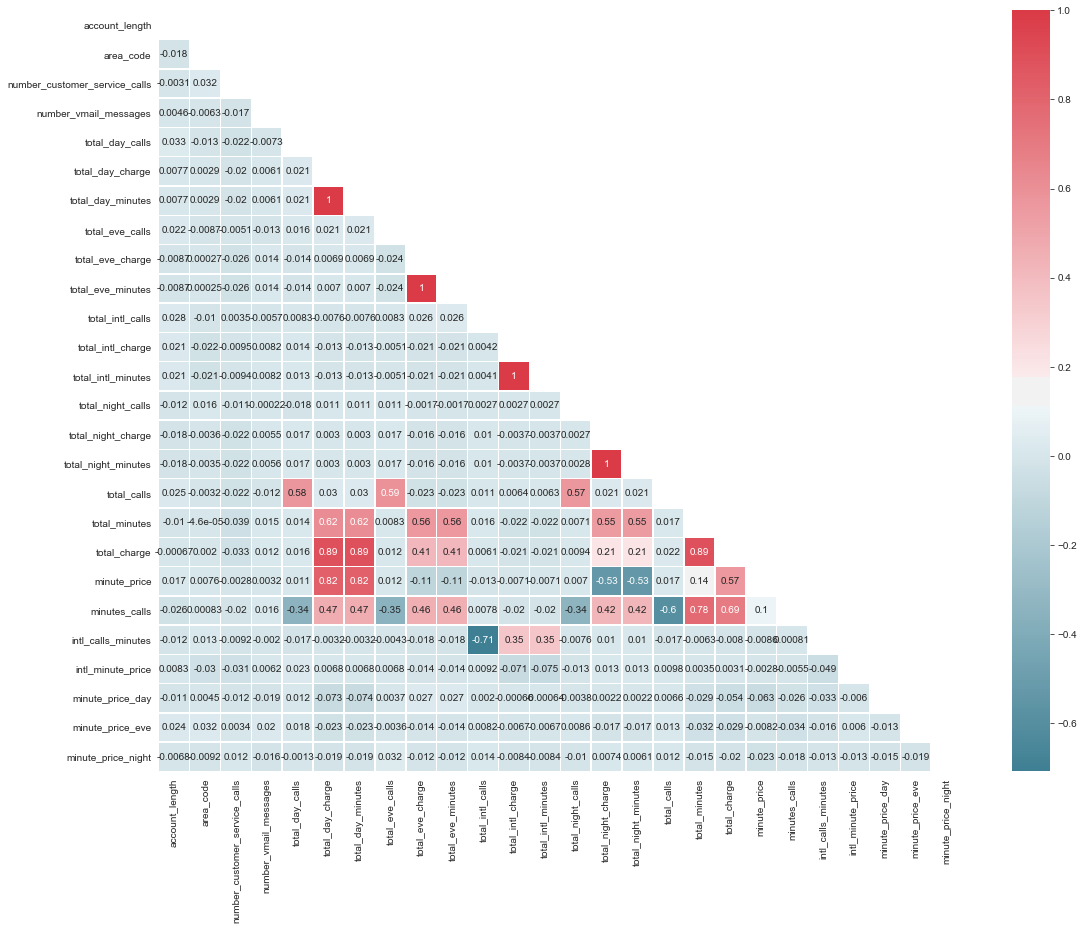

In [461]:
# Calcula as correlações
correlations = train_df_pandas2[numerical_var + ["total_calls", "total_minutes", "total_charge", "minute_price", "minutes_calls", "intl_calls_minutes", "intl_minute_price", "minute_price_day", "minute_price_eve", "minute_price_night"]].corr(method='pearson')

# Uses the variable ax for single a Axes
fig, ax = plt.subplots()

# Figure Size
ax.figure.set_size_inches(18,14)

# Gera uma mascara para o triângulo superior
mask = np.triu(np.ones_like(correlations, dtype=np.bool))

# Gera um colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plots the heatmap
sns.heatmap(correlations, cmap=cmap, mask=mask, linewidths=0.5, annot=True)



In [206]:
corr_unstacked = correlations.abs().unstack()
top_correlations = corr_unstacked.sort_values(kind="quicksort", ascending = False)

In [207]:
pair_corr = pd.DataFrame(top_correlations).reset_index().rename(columns={"level_0": "var1", "level_1": "var2", 0:"corr"})

In [208]:
duplicates_idx = []
for idx in range(len(pair_corr)-1):
    if pair_corr["var1"][idx] == pair_corr["var2"][idx]:
        duplicates_idx.append(idx)

In [209]:
pair_corr.drop(pair_corr.index[duplicates_idx], inplace = True)

In [210]:
pair_corr = pair_corr.drop_duplicates(subset='corr', keep="last")

In [211]:
pair_corr[pair_corr["corr"] < 0.99]

,var1,var2,corr
35,total_minutes,total_charge,0.892437
37,total_charge,total_day_charge,0.888110
39,total_day_minutes,total_charge,0.888108
41,minute_price,total_day_charge,0.820669
43,minute_price,total_day_minutes,0.820667
45,total_minutes,minutes_calls,0.780175
47,total_intl_calls,intl_calls_minutes,0.708616
49,total_charge,minutes_calls,0.693371
51,total_minutes,total_day_charge,0.615391
53,total_day_minutes,total_minutes,0.615389


**Observações**:

As correlações mais relevantes foram:
- total_minutes e total_charge: 0.892
- total_charge e total_day_charge: 0.888
- total_charge e total_day_minutes: 0.888
- total_day_charge e minute_price: 0.820
- total_day_minutes e minute_calls: 0.780


É possível perceber que muitas variáveis estão correlacionadas pois são dependentes uma das outras. Além disso, percebe-se que o as ações no dia são as que mais influenciam nas variáveis "charge" ou preço do minuto chamado.

## 6.0 Preparação dos Dados

Para utilização de um modelo de machine learning, é importante que todas as colunas sejam representadas como números para facilitar o uso de expressões matemáticas, salvo casos em que o modelo consegue entender strings, etc. Para isso, temos técnicas de categorical encoding e normalização/padronização para valores numéricos, visto que isso ajuda o modelo ao deixar os dados na mesma escala.

### 6.1 Conversão dos valores categóricos para numéricos

In [384]:
trainDF3 = spSession.createDataFrame(train_df_pandas2)

In [392]:
trainDF4 = convert_numerical(trainDF3)

In [393]:
train_df_pandas3 = trainDF4.toPandas()

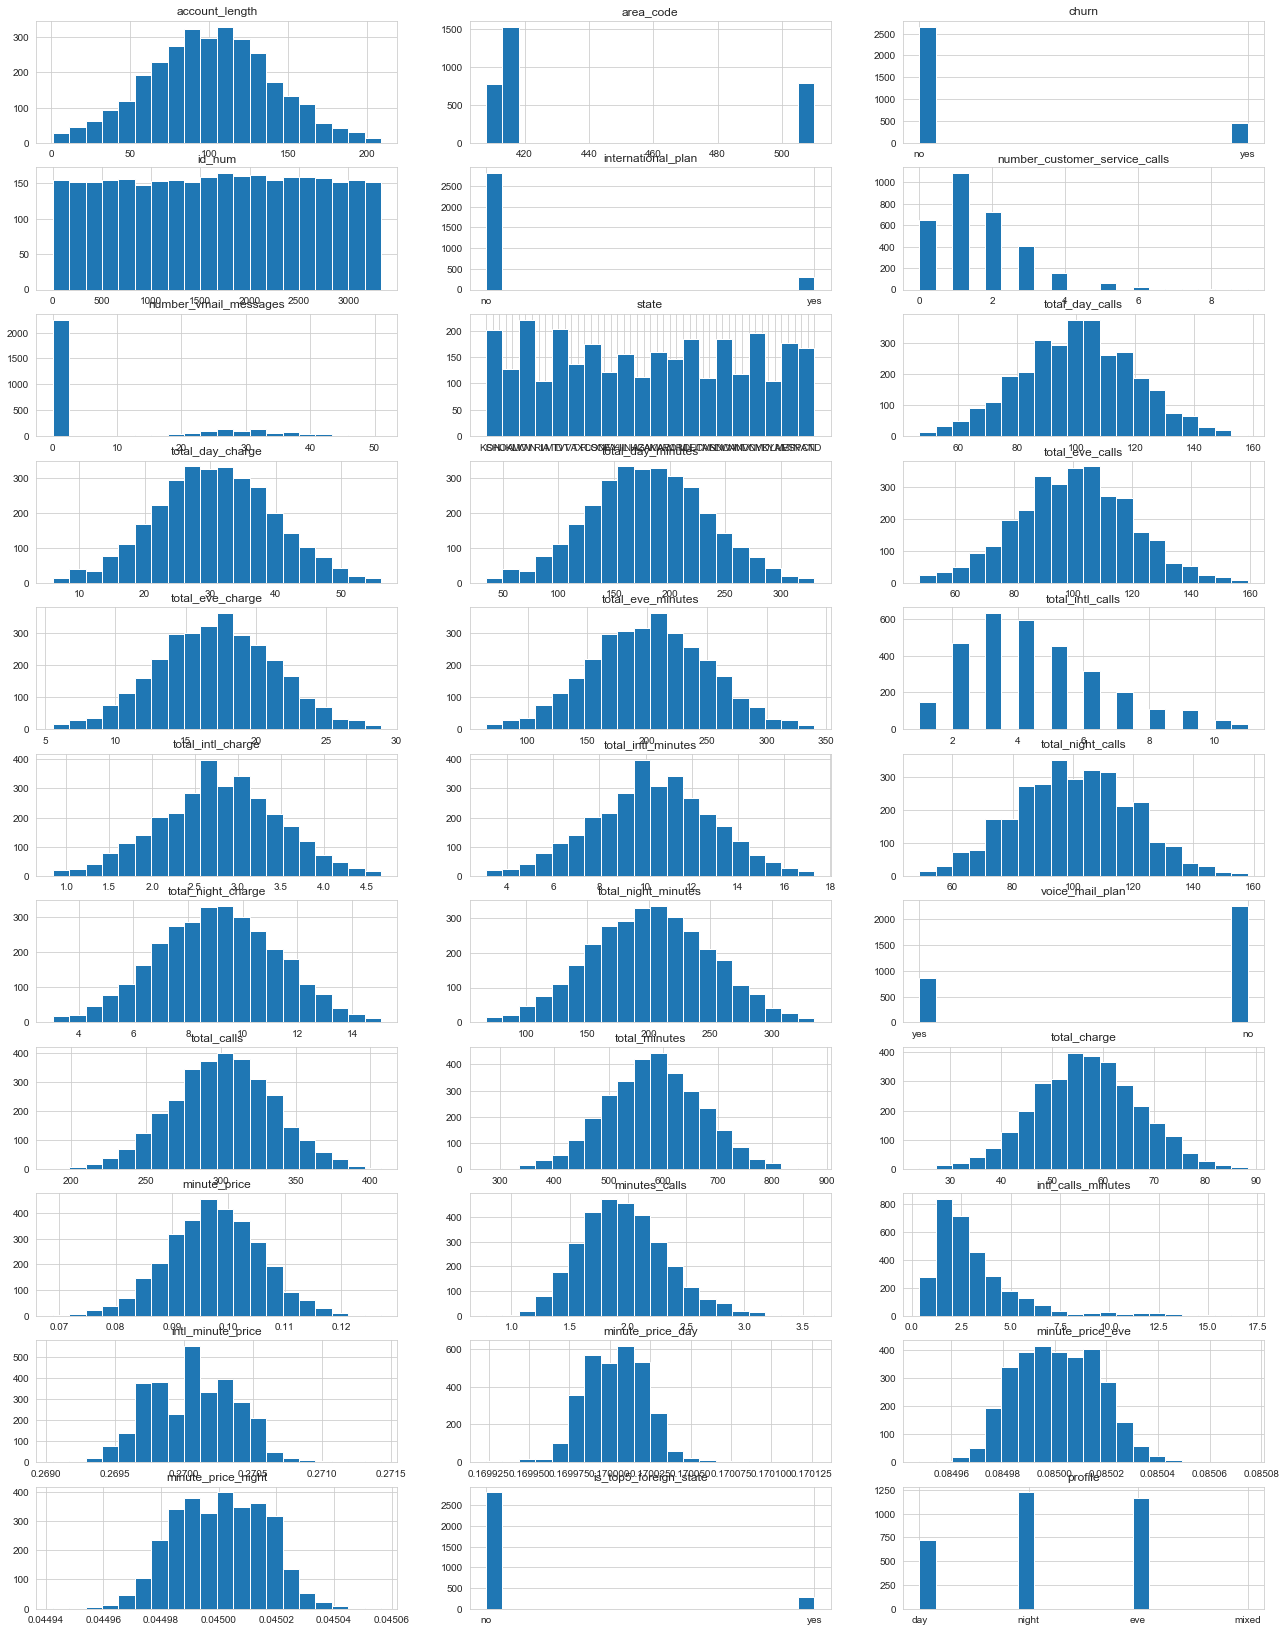

In [394]:
figure, ax = plt.subplots(figsize=(22,40))

n = 1

# Cria um histograma para cada coluna
for col in train_df_pandas2.columns:
    plt.subplot(15, 3, n)
    train_df_pandas2[col].hist(bins = 20)
    plt.title(col)
    n = n+1
    

**Variáveis a serem normalizadas:**

- total_day_calls
- number_vmail_messages
- total_intl_calls
- minute_calls
- intl_calls_minutes

**Variáveis a serem padronizadas:**
- account_length 
- total_day_calls
- total_day_charge
- total_day_minutes 
- total_eve_calls
- total_eve_charge 
- total_eve_minutes
- total_intl_charge 
- total_intl_minutes 
- total_night_calls 
- total_night_charge
- total_night_minutes
- total_calls 
- total_minutes 
- total_charge
- minute_price
- intl_minute_price
- minute_price_day
- minute_price_eve
- minute_price_night

### 6.2 Normalização

Aplica-se a normalização dos dados à variáveis numéricas que preferencialmente não possuam distribuição normal.

In [395]:
norm_var = ["total_day_calls", "number_vmail_messages", "total_intl_calls", "minutes_calls", "intl_calls_minutes"]

In [396]:
minmax_scaler = MinMaxScaler()

In [397]:
train_df_pandas3[norm_var] = minmax_scaler.fit_transform(train_df_pandas3[norm_var])

### 6.3 Padronização

Aplica-se a padronização das variáveis que já estão com distribuição normal, assim, transformando-as com média 0 e std 1.

In [398]:
stand_var = ["account_length", "total_day_calls", "total_day_charge", "total_day_minutes", "total_eve_calls", "total_eve_charge", "total_eve_minutes","total_intl_charge", "total_intl_minutes", "total_night_calls", "total_night_charge","total_night_minutes", "total_calls", "total_minutes", "total_charge", "minute_price", "intl_minute_price", "minute_price_day", "minute_price_eve", "minute_price_night"]

In [399]:
standard_scaler = StandardScaler()

In [400]:
train_df_pandas3[stand_var] = standard_scaler.fit_transform(train_df_pandas3[stand_var])

### 6.4 Removação da Coluna Id_num

In [401]:
train_df_pandas3 = train_df_pandas3.drop(["id_num"], axis = 1)

## 7.0 Aplicando as Transformações aos Dados de Teste

In [402]:
test_df_pandas = testDF.toPandas()

### 7.1 Criando as variáveis da seção de Feature Engineering

In [403]:
test_df_pandas["total_calls"] = test_df_pandas["total_day_calls"] + test_df_pandas["total_eve_calls"] + test_df_pandas["total_night_calls"] 

In [404]:
test_df_pandas["total_minutes"] = test_df_pandas["total_day_minutes"] + test_df_pandas["total_eve_minutes"] + test_df_pandas["total_night_minutes"] 

In [405]:
test_df_pandas["total_charge"] = test_df_pandas["total_day_charge"] + test_df_pandas["total_eve_charge"] + test_df_pandas["total_night_charge"] 

In [406]:
test_df_pandas["minute_price"] = test_df_pandas["total_charge"] / test_df_pandas["total_minutes"] # Quanto ela gasta por minuto

In [407]:
test_df_pandas["minutes_calls"] = test_df_pandas["total_minutes"] / test_df_pandas["total_calls"] # Quanto ela fala por chamada

In [408]:
test_df_pandas["intl_calls_minutes"] = test_df_pandas["total_intl_minutes"] / test_df_pandas["total_intl_calls"] # Quanto ela fala por chamada internacional

In [409]:
test_df_pandas["intl_minute_price"] = test_df_pandas["total_intl_charge"] / test_df_pandas["total_intl_minutes"] # Quanto ela gasta por minuto

In [410]:
test_df_pandas["is_top5_foreign_state"] = test_df_pandas["state"].apply(lambda state: "yes" if state in top5_foreign_states else "no")

In [411]:
test_df_pandas["minute_price_day"] = test_df_pandas["total_day_charge"] / test_df_pandas["total_day_minutes"] # Quanto ela gasta por minuto

In [412]:
test_df_pandas["minute_price_eve"] = test_df_pandas["total_eve_charge"] / test_df_pandas["total_eve_minutes"] # Quanto ela gasta por minuto

In [413]:
test_df_pandas["minute_price_night"] = test_df_pandas["total_night_charge"] / test_df_pandas["total_night_minutes"] # Quanto ela gasta por minuto

In [414]:
test_df_pandas["profile"] = test_df_pandas.apply(lambda x: classify_profile(x["total_day_minutes"], x["total_eve_minutes"], x["total_night_minutes"]), axis = 1)

### 7.2 Normalizando e Padronizando as variáveis

In [415]:
testDF2 = spSession.createDataFrame(test_df_pandas)

In [416]:
testDF3 = convert_numerical(testDF2)

In [417]:
test_df_pandas2 = testDF3.toPandas()

In [418]:
test_df_pandas2[stand_var] = standard_scaler.transform(test_df_pandas2[stand_var])

In [419]:
test_df_pandas2[norm_var] = minmax_scaler.transform(test_df_pandas2[norm_var])

### 7.3 Removendo a coluna Id_Num

In [420]:
test_df_pandas2 = test_df_pandas2.drop(["id_num"], axis = 1)

In [421]:
train_df_pandas3.shape

(3106, 32)

## 8.0 Escolha de Features

Como o modelo contém 34 variáveis, pra facilitar a utilização dos modelos e ganhar tempo, escolheremos as variáveis de 2 maneiras diferentes a fim de comparação:

- Feature Importance com RandomForest
- PCA

### 8.1 Criando um Label Point (Target, Features)

**8.1.1 Dados de Treino**

In [422]:
trainRDD4 = spSession.createDataFrame(train_df_pandas3).rdd.map(transformVar)

In [423]:
train_all = spSession.createDataFrame(trainRDD4,["label", "features"])
train_all.select("features", "label").show(10)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.70083788782006...|    0|
|[0.16391765066727...|    0|
|[0.93094656088554...|    0|
|[-0.6542465202322...|    0|
|[0.44516158441397...|    0|
|[1.18662286429163...|    0|
|[1.03321708224797...|    0|
|[-0.9099228236383...|    1|
|[-0.6798141505728...|    0|
|[1.72354310144442...|    0|
+--------------------+-----+
only showing top 10 rows



**8.1.2 Dados de Teste**

In [424]:
testRDD4 = spSession.createDataFrame(test_df_pandas2).rdd.map(transformVar)

In [425]:
test_all = spSession.createDataFrame(testRDD4,["label", "features"])
test_all.select("features", "label").show(10)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.01051186862361...|    0|
|[0.93094656088554...|    0|
|[0.06164712930483...|    0|
|[-0.0406233920575...|    0|
|[0.18948528100788...|    0|
|[0.41959395407336...|    0|
|[-0.9610580843195...|    0|
|[-0.1684615437606...|    0|
|[0.95651419122615...|    0|
|[0.70083788782006...|    0|
+--------------------+-----+
only showing top 10 rows



### 8.1 Feature Importances

In [427]:
rf = RandomForestClassifier()
model = rf.fit(train_all)
print(model.featureImportances)

(31,[0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],[0.005398031633849266,0.11224804899909198,0.11293633749110857,0.05243259313979586,0.007737918546096091,0.13167614661498697,0.06580718202000675,0.002655019822369258,0.015151442441234295,0.015874900999823575,0.04030179216760627,0.01538359513864285,0.03322344936116523,0.004789868337058519,0.006180216700201795,0.0016971040616914634,0.04362272362547803,0.004820665690132987,0.06857979873672153,0.17194795398880391,0.013228239722343053,0.021415500671213786,0.030573996777480534,0.009680725396536017,0.0004114521000531021,0.0039435316369528985,0.0006535606933271876,0.0027604620596165066,0.0010288214498116387,0.003838919976799938])


In [429]:
features_imp = model.featureImportances.toArray()
feature_names = train_df_pandas3.columns
feature_names = feature_names.drop("churn")

In [430]:
len(features_imp)

31

In [431]:
features = pd.DataFrame({"feature_names": feature_names,
             "features_imp": features_imp}).sort_values("features_imp", ascending = False)

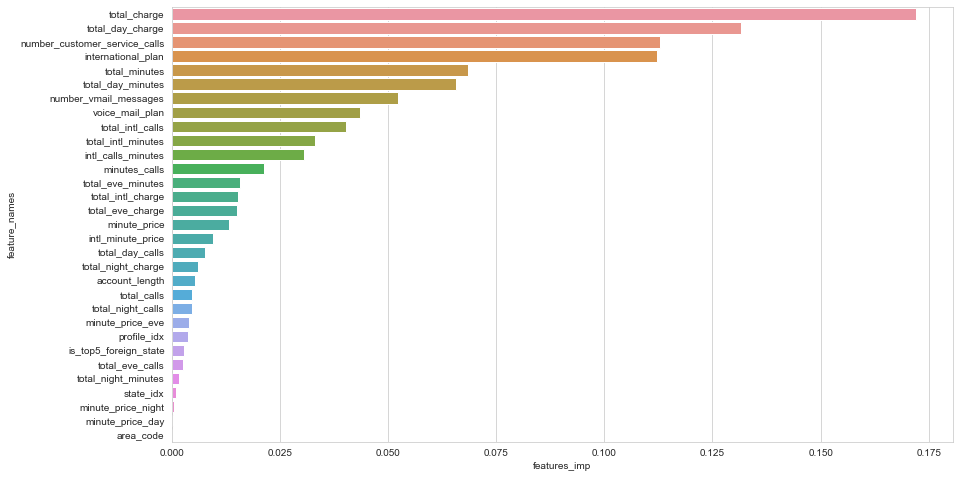

In [432]:
plt.figure(1, figsize=(14,8))
sns.barplot(x = "features_imp", y = "feature_names", data=features, orient = 'h')

A partir do modelo de feature importances gerado pelo Random Forest, podemos selecionar as variáveis que mais impactam o modelo. Com isso, as variáveis selecionadas são:

- total_charge
- total_day_charge
- number_customer_service_calls
- international_plan
- total_day_minutes
- total_minutes
- number_vmail_messages
- voice_mail_plan
- intl_calls_minutes
- total_intl_minutes
- minutes_calls
- minute_price


In [436]:
trainRDD5 = spSession.createDataFrame(train_df_pandas3).rdd.map(transform_selected_vars)

In [437]:
train_selected = spSession.createDataFrame(trainRDD5,["label", "features"])
train_selected.select("features", "label").show(10)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.57622796573144...|    0|
|[-0.1251315134721...|    0|
|[0.21474745870130...|    0|
|[-0.7321985793773...|    0|
|[0.89352309388011...|    0|
|[-1.1624499950189...|    0|
|[2.03398403808068...|    0|
|[-0.5936929866708...|    1|
|[-0.2155039569402...|    0|
|[-1.9296334553295...|    0|
+--------------------+-----+
only showing top 10 rows



In [438]:
testRDD5 = spSession.createDataFrame(test_df_pandas2).rdd.map(transform_selected_vars)

In [439]:
test_selected = spSession.createDataFrame(testRDD5,["label", "features"])
test_selected.select("features", "label").show(10)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-1.5848429373154...|    0|
|[0.61356498096266...|    0|
|[2.64890957733095...|    0|
|[0.07034801098598...|    0|
|[-0.3451687671336...|    0|
|[0.37093461643420...|    0|
|[1.01434712156027...|    0|
|[0.29824373799247...|    0|
|[-2.1919100032206...|    0|
|[-0.5229667265653...|    0|
+--------------------+-----+
only showing top 10 rows



### 8.2 PCA

In [440]:
# Aplicando Redução de Dimensionalidade com PCA
PCA_obj = PCA(k = 8, inputCol = "features", outputCol = "pcaFeatures")
pcaModel = PCA_obj.fit(train_all)
train_PCA = pcaModel.transform(train_all).select("label","pcaFeatures")


In [441]:
test_PCA = pcaModel.transform(test_all).select("label","pcaFeatures")

## 9.0 Modelos de Machine Learning

Na etapa de modelos, abordaremos 3 tipos de modelos utilizando a biblioteca MLLib do Pyspark. Os modelos escolhidos foram:

- Regressão Logística
- Naive Bayes
- Random Forest

In [442]:
# Colocando os modelos em cache para melhor aproveitamento da memória
train_all.cache()
test_all.cache()
train_selected.cache()
test_selected.cache()
train_PCA.cache()
test_PCA.cache()

DataFrame[label: bigint, pcaFeatures: vector]

### 9.1 Regressão Logística

In [443]:
# Logistic Regression
lr_all = LogisticRegression(labelCol="label", featuresCol="features")
model_all = lr_all.fit(train_all)

# Previsões com dados de teste
predictions = model_all.transform(test_all)
predictions.select("prediction", "label", "features").first()


evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "accuracy")
print("Accuracy nos dados de teste com todas as variáveis:", evaluator.evaluate(predictions))
# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()

Accuracy nos dados de teste com todas as variáveis: 0.8782243551289742
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  153|
|    0|       1.0|   50|
|    0|       0.0| 1393|
|    1|       1.0|   71|
+-----+----------+-----+



In [444]:
# Logistic Regression
lr_sel = LogisticRegression(labelCol="label", featuresCol="features")
model_sel = lr_sel.fit(train_selected)

# Previsões com dados de teste
predictions = model_sel.transform(test_selected)
predictions.select("prediction", "label", "features").first()


evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "accuracy")
print("Accuracy nos dados de teste com as melhores 12 variáveis:", evaluator.evaluate(predictions))
# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()

Accuracy nos dados de teste com as melhores 12 variáveis: 0.877624475104979
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  163|
|    0|       1.0|   41|
|    0|       0.0| 1402|
|    1|       1.0|   61|
+-----+----------+-----+



In [445]:
# Logistic Regression
lr_PCA = LogisticRegression(labelCol="label", featuresCol="pcaFeatures")
model_PCA = lr_PCA.fit(train_PCA)

# Previsões com dados de teste
predictions = model_PCA.transform(test_PCA)
predictions.select("prediction", "label", "pcaFeatures").first()


evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "accuracy")
print("Accuracy nos dados de teste com PCA:", evaluator.evaluate(predictions))
# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()

Accuracy nos dados de teste com PCA: 0.8650269946010798
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  206|
|    0|       1.0|   19|
|    0|       0.0| 1424|
|    1|       1.0|   18|
+-----+----------+-----+



Utilizando o algoritmo de Regressão Logística, o melhor resultado apresentado é com todas as variáveis, entretanto, é possível reduzir a complexidade do modelo utilizando apenas 12, visto que a diferença de precisão é muito baixa.

### 9.2 Decision Tree

In [446]:
# Decision Tree
dt_all = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model_all = dt_all.fit(train_all)

# Previsões com dados de teste
predictions = model_all.transform(test_all)
predictions.select("prediction", "label", "features").first()


evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "accuracy")
print("Accuracy nos dados de teste com todas as variáveis:", evaluator.evaluate(predictions))
# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()

Accuracy nos dados de teste com todas as variáveis: 0.9652069586082783
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   47|
|    0|       1.0|   11|
|    0|       0.0| 1432|
|    1|       1.0|  177|
+-----+----------+-----+



In [447]:
# Decision Tree
dt_sel = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model_sel = dt_sel.fit(train_selected)

# Previsões com dados de teste
predictions = model_sel.transform(test_selected)
predictions.select("prediction", "label", "features").first()


evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "accuracy")
print("Accuracy nos dados de teste com as melhores 12 variáveis:", evaluator.evaluate(predictions))
# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()

Accuracy nos dados de teste com as melhores 12 variáveis: 0.9664067186562687
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   45|
|    0|       1.0|   11|
|    0|       0.0| 1432|
|    1|       1.0|  179|
+-----+----------+-----+



In [448]:
# Decision Tree
dt_PCA = DecisionTreeClassifier(labelCol="label", featuresCol="pcaFeatures")
model_PCA = dt_PCA.fit(train_PCA)

# Previsões com dados de teste
predictions = model_PCA.transform(test_PCA)
predictions.select("prediction", "label", "pcaFeatures").first()


evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "accuracy")
print("Accuracy nos dados de teste com PCA:", evaluator.evaluate(predictions))
# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()

Accuracy nos dados de teste com PCA: 0.9190161967606478
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  101|
|    0|       1.0|   34|
|    0|       0.0| 1409|
|    1|       1.0|  123|
+-----+----------+-----+



Como observado acima, utilizando um algoritmo de árvore de decisão, a acurácia do modelo aumenta consideravelmente, em que o modelo com as melhores 12 variáveis apresentou o melhor desempenho.

### 9.3 Random Forest

In [449]:
# Random Forest
rf_all = RandomForestClassifier(labelCol="label", featuresCol="features")
model_all = rf_all.fit(train_all)

# Previsões com dados de teste
predictions = model_all.transform(test_all)
predictions.select("prediction", "label", "features").first()


evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "accuracy")
print("Accuracy nos dados de teste com todas as variáveis:", evaluator.evaluate(predictions))
# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()

Accuracy nos dados de teste com todas as variáveis: 0.9424115176964607
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   92|
|    0|       1.0|    4|
|    0|       0.0| 1439|
|    1|       1.0|  132|
+-----+----------+-----+



In [450]:
# Random Forest
rf_sel = RandomForestClassifier(labelCol="label", featuresCol="features")
model_sel = rf_sel.fit(train_selected)

# Previsões com dados de teste
predictions = model_sel.transform(test_selected)
predictions.select("prediction", "label", "features").first()


evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "accuracy")
print("Accuracy nos dados de teste com as melhores 12 variáveis:", evaluator.evaluate(predictions))
# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()

Accuracy nos dados de teste com as melhores 12 variáveis: 0.9448110377924415
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   85|
|    0|       1.0|    7|
|    0|       0.0| 1436|
|    1|       1.0|  139|
+-----+----------+-----+



In [451]:
# Random Forest
rf_PCA = RandomForestClassifier(labelCol="label", featuresCol="pcaFeatures")
model_PCA = rf_PCA.fit(train_PCA)

# Previsões com dados de teste
predictions = model_PCA.transform(test_PCA)
predictions.select("prediction", "label", "pcaFeatures").first()


evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "accuracy")
print("Accuracy nos dados de teste com PCA:", evaluator.evaluate(predictions))
# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()

Accuracy nos dados de teste com PCA: 0.9196160767846431
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  116|
|    0|       1.0|   18|
|    0|       0.0| 1425|
|    1|       1.0|  108|
+-----+----------+-----+



O melhor desempenho do modelo de ensemble com diferentes técnicas de seleção de variáveis/redução de dimensionalidade foi também utilizando as 12 melhores variáveis.

## 10.0 Hyperparameters Fine-Tuning

Como o modelo que apresentou melhor resultado foi o Decision Tree com as melhores 12 variáveis escolhidas através do Feature Importance, a penúltima etapa do projeto é tentar pegar esse modelo e fazer um tuning de hyperparâmetros, a fim de obter a melhor acurácia possível.

In [452]:
# Create ParamGrid for Cross Validation
dtparamGrid = (ParamGridBuilder()
               .addGrid(dt_sel.maxDepth, [2, 5, 10])
               .addGrid(dt_sel.maxBins, [5, 10, 20])
               .addGrid(dt_sel.minInstancesPerNode, [2, 4, 8])
             .build())

In [453]:
# Create 5-fold CrossValidator
dtcv = CrossValidator(estimator = dt_sel,
                      estimatorParamMaps = dtparamGrid,
                      evaluator = evaluator,
                      numFolds = 5)

In [454]:
dtcvModel = dtcv.fit(train_selected)

In [455]:
print(dtcvModel)

CrossValidatorModel_9b23108f4bec


In [456]:
dtpredictions = dtcvModel.transform(test_selected)

In [457]:
# Avalia o melhor modelo encontrado
print('Accuracy:', evaluator.evaluate(dtpredictions))
dtpredictions.groupBy("label", "prediction").count().show()

Accuracy: 0.9598080383923215
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   46|
|    0|       1.0|   21|
|    0|       0.0| 1422|
|    1|       1.0|  178|
+-----+----------+-----+



A melhor acurácia do modelo foi sem o tuning de hyperparâmetros.

## 11.0 Resumo do Projeto

Ao final do projeto, resume-se tudo que foi solicitado pelo CEO da empresa:

- Qual é o Churn Rate da Operadora hoje? 

**Resposta:** Em torno de 14%.

- Qual é a performance do modelo ao classificar clientes em Churn? 

**Resposta:** A performance do melhor modelo (Decision Tree com 12 variáveis) foi de 96.64% de acurácia e precisão de 79.91%.

Além disso, conseguimos identificar que:

- Quem tem plano internacional e usufrui muito pouco disso, tem mais chance de deixar a operadora;
- Quem reclama mais de 4 vezes ao call center possui alta probabilidade de churn;
- Estados com mais imigrantes tendem à ter um cancelamento do plano;
- Clientes novos (menos de 100 dias de relacionamento) possuem mais probabilidade de churn;
- Estados como Califórnia, New Jersey, Texas, entre outros, possuem um Churn Rate muito alto, necessitando de um olhar especial.
- O preço do minuto do dia é mais caro que a noite e a madrugada. Também constatou-se que as pessoas que estão em churn falam mais durante o dia, o que leva a cobrança ser maior, provavelmente influenciando na não renovação do plano.